# Figures to apply Gaussian Mixture Models to GALAH DR3

We will apply Gaussian Mixture Models to tell apart the accreted halo stars from the disk, in a plane similar to Das et al. (2020)

#### Author(s):
Sven Buder

#### History:
210428: Created

![](literature/2020MNRAS...493..5195_Fig4.png)

In [160]:
plot_again = False

In [161]:
# Preamble for notebook 

# Compatibility with Python 3
from __future__ import (absolute_import, division, print_function)

try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Basic packages
import warnings
warnings.filterwarnings("ignore")
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
from astropy.table import Table, join
import astropy.units as u
from sklearn import mixture
from xdgmm import XDGMM
import scipy.stats
from scipy import linalg
import pickle
import astropy.units as u
#import seaborn as sns
import corner
#import itertools
#import galpy.util.bovy_coords as bc
#import time
#import resource 
from statsmodels.stats.weightstats import DescrStatsW

# Matplotlib and associated packages for plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.colors import LogNorm

panels = ['a)','b)','c)','d)','e)','f)','g)','h)','i)','j)']

params = {
    'font.family'        : 'serif',
    'text.usetex'        : True, 
    'text.latex.preamble': [r'\usepackage{upgreek}', r'\usepackage{amsmath}'],
    }   

plt.rcParams.update(params)

In [162]:
def get_and_join_data(directory = '../data/'):
    
    # Join all data
    galah_dr3_main = Table.read(directory+'GALAH_DR3_main_allspec_v2.fits')
    galah_dr3_dynamics = Table.read(directory+'GALAH_DR3_VAC_dynamics_v2.fits')
    galah_dr3_gaiaedr3 = Table.read(directory+'GALAH_DR3_VAC_GaiaEDR3_v2.fits')
    galah_dr3_ages = Table.read(directory+'GALAH_DR3_VAC_ages_v2.fits')
    galah_dr3_rv = Table.read(directory+'GALAH_DR3_VAC_rv_v2.fits')
    data_12 = join(galah_dr3_main, galah_dr3_dynamics, keys='sobject_id')
    data_123 = join(data_12, galah_dr3_gaiaedr3, keys='sobject_id')
    data_1234 = join(data_123, galah_dr3_ages, keys='sobject_id')
    data = join(data_1234, galah_dr3_rv, keys='sobject_id')
    
    # get best rv and e_rv
    data['best_rv'] = np.zeros(len(data['sobject_id'])); data['best_rv'][:] = np.nan;
    data['best_rv'][data['use_rv_flag_1']==0] = data['rv_obst'][data['use_rv_flag_1']==0]
    data['best_rv'][data['use_rv_flag_1']==1] = data['rv_sme_v2'][data['use_rv_flag_1']==1]
    data['best_rv'][data['use_rv_flag_1']==2] = data['dr2_radial_velocity_1'][data['use_rv_flag_1']==2]

    data['best_e_rv'] = np.zeros(len(data['sobject_id'])); data['best_e_rv'][:] = np.nan;
    data['best_e_rv'][data['use_rv_flag_1']==0] = data['e_rv_obst'][data['use_rv_flag_1']==0]
    data['best_e_rv'][data['use_rv_flag_1']==1] = data['e_rv_sme'][data['use_rv_flag_1']==1]
    data['best_e_rv'][data['use_rv_flag_1']==2] = data['dr2_radial_velocity_error_1'][data['use_rv_flag_1']==2]
    
    # get best distance and 16th + 84th percentile
    data['best_d'] = np.zeros(len(data['sobject_id'])); data['best_d'][:] = np.nan;
    data['best_d_16'] = np.zeros(len(data['sobject_id'])); data['best_d_16'][:] = np.nan;
    data['best_d_50'] = np.zeros(len(data['sobject_id'])); data['best_d_50'][:] = np.nan;
    data['best_d_84'] = np.zeros(len(data['sobject_id'])); data['best_d_84'][:] = np.nan;

    data['best_d'][data['use_dist_flag']==0] = 1000.*data['distance_bstep'][data['use_dist_flag']==0]
    data['best_d_16'][data['use_dist_flag']==0] = 1000.*data['e16_distance_bstep'][data['use_dist_flag']==0]
    data['best_d_50'][data['use_dist_flag']==0] = 1000.*data['e50_distance_bstep'][data['use_dist_flag']==0]
    data['best_d_84'][data['use_dist_flag']==0] = 1000.*data['e84_distance_bstep'][data['use_dist_flag']==0]

    data['best_d'][data['use_dist_flag']==1] = data['r_med_photogeo'][data['use_dist_flag']==1]
    data['best_d_16'][data['use_dist_flag']==1] = data['r_lo_photogeo'][data['use_dist_flag']==1]
    data['best_d_50'][data['use_dist_flag']==1] = data['r_med_photogeo'][data['use_dist_flag']==1]
    data['best_d_84'][data['use_dist_flag']==1] = data['r_hi_photogeo'][data['use_dist_flag']==1]

    data['best_d'][data['use_dist_flag']==2] = data['r_med_geo'][data['use_dist_flag']==2]
    data['best_d_16'][data['use_dist_flag']==2] = data['r_lo_geo'][data['use_dist_flag']==2]
    data['best_d_50'][data['use_dist_flag']==2] = data['r_med_geo'][data['use_dist_flag']==2]
    data['best_d_84'][data['use_dist_flag']==2] = data['r_hi_geo'][data['use_dist_flag']==2]

    data['best_d'][data['use_dist_flag']==4] = 1000./data['parallax_corr'][data['use_dist_flag']==4]
    data['best_d_16'][data['use_dist_flag']==4] = 1000./(data['parallax_corr'][data['use_dist_flag']==4]+data['parallax_error'][data['use_dist_flag']==4])
    data['best_d_50'][data['use_dist_flag']==4] = 1000./(data['parallax_corr'][data['use_dist_flag']==4]-data['parallax_error'][data['use_dist_flag']==4])
    data['best_d_84'][data['use_dist_flag']==4] = 1000./data['r_hi_geo'][data['use_dist_flag']==4]

    data['theta_spherical'] = np.arctan2(data['R_Rzphi'], data['z_Rzphi'])
    data['rho_spherical'] = np.sqrt((data['R_Rzphi'])**2+(data['z_Rzphi'])**2)
    data['vrho_spherical'] = (data['R_Rzphi']*data['vR_Rzphi'] + data['z_Rzphi']*data['vz_Rzphi'])/data['rho_spherical']
    data['vtheta_spherical'] = (data['z_Rzphi']*data['vR_Rzphi'] - data['R_Rzphi']*data['vz_Rzphi'])/data['rho_spherical']

    data['MgMn_fe'] = data['Mg_fe'] - data['Mn_fe']
    data['e_MgMn_fe'] = np.sqrt((data['e_Mg_fe'])**2+(data['e_Mn_fe'])**2)
    data['flag_MgMn_fe'] = np.max([data['flag_Mg_fe'],data['flag_Mn_fe']],axis=0)
    data['sqrt_J_R'] = np.sqrt(data['J_R'])
    
    return data

# test if joined data file already exists
try:
    data = Table.read('../../data/GALAH_DR3_all_joined_v2.fits')
except:
    data = get_and_join_data(directory = '../../data/')
    data.write('../../data/GALAH_DR3_all_joined_v2.fits',overwrite=True)

In [163]:
# Selection basics 

basic_cuts = (
    (data['flag_sp'] == 0) &
    (data['survey_name'] != 'other') &
    (data['flag_fe_h'] == 0) &
    (data['best_d'] <= 10000.) &
    np.isfinite(data['L_Z']) &
    np.isfinite(data['ecc']) &
    np.isfinite(data['age_bstep'])
)

basic_cuts_mgalpha = (
    basic_cuts &
    (data['flag_alpha_fe'] == 0) &
    (data['flag_Mg_fe'] == 0)
)

def nissen_slope_mg_fe(fe_h):
    """
    Slope [Fe/H] vs. [Mg/Fe] as estimated from 2010A%26A...511L..10N
    
    -1/12 * [Fe/H] + 1/6
    
    """
    return -0.1/1.2*(fe_h)+(0.3 - 1.6*0.1/1.2)

def nissen_slope_alpha_fe(fe_h):
    """
    Slope [Fe/H] vs. [alpha/Fe] as estimated from 2010A%26A...511L..10N
    
    -0.2/1.2*(fe_h)+(0.325 - 1.6*0.2/1.2)
    
    -1/6 * [Fe/H] + 0.7/12
    
    """
    return -0.2/1.2*(fe_h)+(0.325 - 1.6*0.2/1.2)

def total_velocity(data):
    """
    return the total space velocity:
    
    sqrt(pow(rv_galah,2) + (pow(4.7623*r_est/1000.,2)*(pow(pmra,2) + pow(pmdec,2))))
    
    """
    return(
        np.sqrt(
            (data['U_UVW']-11.1)**2 +
            (data['V_UVW']+15.17)**2 +
            (data['W_UVW']+7.25)**2
        )
    )

def total_velocity_rv_pm(data):
    """
    return the total space velocity:
    
    sqrt(pow(rv_galah,2) + (pow(4.7623*r_est/1000.,2)*(pow(pmra,2) + pow(pmdec,2))))
    
    """
    return np.sqrt(
            (data['best_rv'])**2 + 
            (4.7623*data['best_d']/1000.)**2 * 
            ((data['pmra'])**2 + (data['pmdec'])**2)
        )

def tangential_velocity(data):
    return (4.7623*data['best_d']/1000.)*np.sqrt((data['pmra'])**2 + (data['pmdec'])**2)

rgb = (
    (data['teff'] < 5500) &
    (data['logg'] < 3.25)
)

msto = (
    (data['teff'] >= 5350) &
    (data['logg'] >= 3.5)
)

stars_with_high_vtot = (
    basic_cuts_mgalpha & 
    (total_velocity(data) > 180)
)

stars_with_high_vtot_rv_pm = (
    basic_cuts_mgalpha & 
    (total_velocity_rv_pm(data) > 180)
)

stars_with_high_vtan = (
    basic_cuts_mgalpha & 
    (tangential_velocity(data) > 180)
)

preliminary_low_alpha_halo = (
    basic_cuts_mgalpha &
    (total_velocity(data) > 180) &
    (data['fe_h'] >= -2.0) & (data['fe_h'] <= -0.5) &
    (data['Mg_fe'] < nissen_slope_mg_fe(data['fe_h'])) &
    (data['alpha_fe'] < nissen_slope_alpha_fe(data['fe_h']))#&
#     (~(data['Na_fe'] >= 0.0))&
#     (data['flag_Na_fe'] == 0.)
)

preliminary_high_alpha_halo = (
    basic_cuts_mgalpha &
    (total_velocity(data) > 180) &
    (data['fe_h'] >= -2.0) & (data['fe_h'] <= -0.5) &
    (data['Mg_fe'] >= nissen_slope_mg_fe(data['fe_h'])) &
    (data['alpha_fe'] >= nissen_slope_alpha_fe(data['fe_h']))
)

# Selection via [Mg/Cu] vs. [Na/Fe]
chem1 = (
    basic_cuts &
    (data['flag_Mg_fe'] == 0) &
    (data['flag_Na_fe'] == 0) &
    (data['flag_Cu_fe'] == 0) &
    (data['Mg_fe'] - data['Cu_fe'] > 0.5) &
    (data['Na_fe'] < -0.1)
)

# Selection via [Mg/Mn] vs. [Na/Fe]
chem2 = (
    basic_cuts &
    (data['flag_Mg_fe'] == 0) &
    (data['flag_Mn_fe'] == 0) &
    (data['flag_Na_fe'] == 0) &
    (np.abs(data['Mg_fe'] - data['Mn_fe'] - 0.5) <= 0.25) &
    (data['Na_fe'] < -0.1)
)

# Selection via [Mg/Mn] vs. [Na/Fe] + [Fe/H]
chem2_mp = (
    basic_cuts &
    (data['flag_Mg_fe'] == 0) &
    (data['flag_Mn_fe'] == 0) &
    (data['flag_Na_fe'] == 0) &
    (np.abs(data['Mg_fe'] - data['Mn_fe'] - 0.5) <= 0.25) &
    (data['Na_fe'] < -0.1) &
    (data['fe_h'] <= -0.5)
)


# Selection via [Mg/Mn] vs. [Al/Fe], like Das+2020 'blob' selection
chem3 = (
    basic_cuts &
    (data['flag_Mg_fe'] == 0) &
    (data['flag_Al_fe'] == 0) &
    (data['flag_Mn_fe'] == 0) &
    (np.abs(data['Al_fe'] - (-0.35)) <= 0.25) &
    (np.abs(data['Mg_fe'] - data['Mn_fe'] - 0.5) <= 0.25)
)

# Selection via [Mg/Mn] vs. [Al/Fe] + [Fe/H] like Das+2020 'metal-poor blob' selection
chem3_mp = (
    basic_cuts &
    (data['flag_Mg_fe'] == 0) &
    (data['flag_Al_fe'] == 0) &
    (data['flag_Mn_fe'] == 0) &
    (np.abs(data['Al_fe'] - (-0.35)) <= 0.25) &
    (np.abs(data['Mg_fe'] - data['Mn_fe'] - 0.5) <= 0.25) &
    (data['fe_h'] < -0.5)
)

# Selection via L_Z and J_R like Feuillet+2020
feuillet2020 = (
    basic_cuts &
    (data['L_Z'] >= -500) &
    (data['L_Z'] <= 500) &
    (data['J_R'] >= 30**2) &
    (data['J_R'] <= 50**2)
)


# Selection via L_Z and E like Helmi+2018
helmi2018 = (
    basic_cuts & 
    (data['L_Z'] > -1500) &
    (data['L_Z'] < 150) &
    (data['Energy'] > -1.8*10**5)
)

# Selection like Naidu+2020, excluding Sagitarius, Alpeh, high-alpha disk and then selection via eccentricity
#naidu2020_sagitarius = (data['L_Y'] < -0.3*data['L_Z'] - 2.5*10**3)
naidu2020_aleph = (
    (data['vT_Rzphi'] < -175) &
    (data['vT_Rzphi'] > 300) & 
    (np.abs(data['vR_Rzphi']) < 75) & 
    (data['fe_h'] > -0.8) & 
    (data['alpha_fe'] < 0.27)
)
naidu2020_highalphadisk = (
    (data['alpha_fe'] > 0.25 - 0.5*(data['fe_h'] + 0.7))
)
naidu2020 = (
    basic_cuts & 
    (data['flag_fe_h'] == 0) &
    (data['flag_alpha_fe'] == 0) &
    # Sagitarius
    (~naidu2020_aleph) &
    (~naidu2020_highalphadisk) &
    (data['ecc'] > 0.7)
)

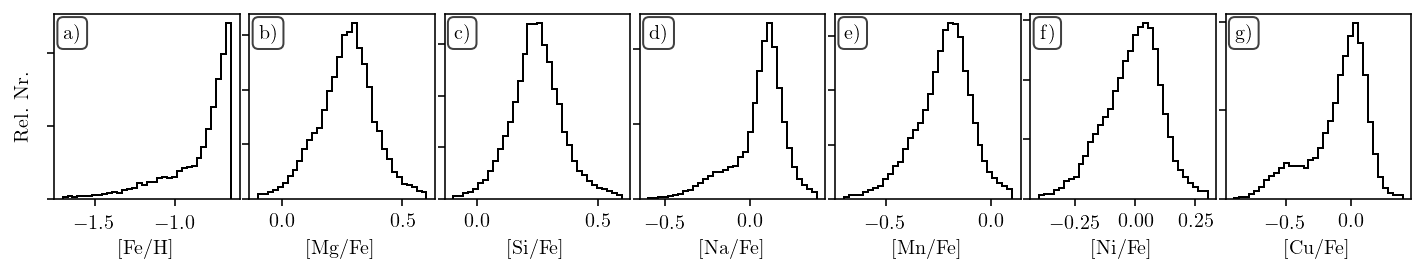

In [164]:
def plot_hist_high_separation_elements():
    f, gs = plt.subplots(1,7,figsize=(10,2))
    selection = (
        basic_cuts &
        (data['flag_Mg_fe'] == 0) &
        (data['flag_Si_fe'] == 0) &
        (data['flag_Na_fe'] == 0) &
        (data['flag_Mn_fe'] == 0) &
        (data['flag_Ni_fe'] == 0) &
        (data['flag_Cu_fe'] == 0) &
        (data['fe_h'] < -0.6)
    )

    for ind, (elem, label, range) in enumerate(zip(
        ['fe_h','Mg_fe','Si_fe','Na_fe','Mn_fe','Ni_fe','Cu_fe'],
        ['[Fe/H]','[Mg/Fe]','[Si/Fe]','[Na/Fe]','[Mn/Fe]','[Ni/Fe]','[Cu/Fe]'],
        [(-1.7,-0.65),(-0.1,0.6), (-0.1,0.6), (-0.6,0.4), (-0.7,0.1),(-0.4,0.3),(-0.9,0.4)])):

        ax=gs[ind]
        ax.hist(
            data[elem][selection],
            bins=np.linspace(range[0],range[1],35),
            range=range,
            histtype='step',
            color='k'
        )
        ax.set_yticklabels([])
        if ind==0:
            ax.set_ylabel('Rel. Nr.')
        ax.set_xlabel(label)
        ax.text(0.05,0.95,panels[ind],transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    plt.tight_layout(h_pad=0,w_pad=0)
    plt.savefig('hist_high_separation_elements.png',dpi=200,bbox_inches='tight')
    
plot_hist_high_separation_elements()

In [165]:
def plot_2d_corner():

    selection = (
        basic_cuts &
        (data['flag_Mg_fe'] == 0) &
        (data['flag_Si_fe'] == 0) &
        (data['flag_Na_fe'] == 0) &
        (data['flag_Mn_fe'] == 0) &
        (data['flag_Ni_fe'] == 0) &
        (data['flag_Cu_fe'] == 0) &
        (data['fe_h'] < -0.6)
    )

    corner.corner(
        np.array([
            data['fe_h'][selection],
            data['Mg_fe'][selection],
            data['Si_fe'][selection],
            data['Na_fe'][selection],
            data['Mn_fe'][selection],
            data['Ni_fe'][selection],
            data['Cu_fe'][selection]
        ]).T,
        bins=35,
        labels = ['[Fe/H]','[Mg/Fe]','[Si/Fe]','[Na/Fe]','[Mn/Fe]','[Ni/Fe]','[Cu/Fe]'],
        label_kwargs = dict(fontsize=20),
        range = [(-1.7,-0.65),(-0.1,0.6), (-0.1,0.6), (-0.6,0.4), (-0.7,0.1),(-0.4,0.3),(-0.9,0.4)]
    );
    plt.savefig('corner_plot_6.png',dpi=150,bbox_inches='tight')

if plot_again:
    plot_2d_corner()

In [166]:
# Print Pearson Coefficients for elements.

galah_elements = ['Fe','alpha','Li','C','O',
                  'Na','Mg','Al','Si','K',
                  'Ca','Sc','Ti','V' ,'Cr',
                  'Mn','Co','Ni','Cu','Zn',
                  'Rb','Sr','Y' ,'Zr','Ba',
                  'La','Ce','Ru','Nd','Eu']

diff_ps = 1.0

def calculate_correlation(galah_elements):
    for ix, ex in enumerate(galah_elements[:1]):
        for iy, ey in enumerate(galah_elements):
            if iy > ix:
                if ex == 'Fe':
                    flagx = 'flag_fe_h'
                    valuex = 'fe_h'
                    errx = 'e_fe_h'
                else:
                    flagx = 'flag_'+ex+'_fe'
                    valuex = ex+'_fe'
                    errx = 'e_'+ex+'_fe'
                if ey == 'Fe':
                    flagy = 'flag_fe_h'
                    valuey = 'fe_h'
                    errx = 'e_fe_h'
                else:
                    flagy = 'flag_'+ey+'_fe'
                    valuey = ey+'_fe'
                    erry = 'e_'+ey+'_fe'

                selection = (
                    basic_cuts & 
                    (data['fe_h'] < -0.6) &
                    (data[flagx]==0) &
                    (data[flagy]==0) &
                    (data[errx] <= 0.15) &
                    (data[erry] <= 0.15)
                )
                if len(data[valuex][selection]) > 500:
                    pearsonnumber = scipy.stats.pearsonr(
                        x = data[valuex][selection],
                        y = data[valuey][selection],
                    )
                    spearmannumber = scipy.stats.spearmanr(
                        data[valuex][selection],
                        data[valuey][selection],
                    )
                if np.abs(pearsonnumber[0]) > 0.6:
                    print(ex,ey,"{:.2f}".format(pearsonnumber[0]))
                if ex=='Fe':
                    print(ex,ey,"{:.2f}".format(pearsonnumber[0]))
                    
if plot_again:
    calculate_correlation(galah_elements)

In [167]:
def plot_2d_corner_sigma():

    elements = ['Mg','Si','Mn','Ni','Cu']

    selection = (
        basic_cuts &
        (data['flag_Mg_fe'] == 0) &
        (data['flag_Si_fe'] == 0) &
        (data['flag_Na_fe'] == 0) &
        (data['flag_Mn_fe'] == 0) &
        (data['flag_Ni_fe'] == 0) &
        (data['flag_Cu_fe'] == 0) &
        (data['fe_h'] < -0.6)
    )

    # Weighted by uncertainty
    corner.corner(
        np.array([
            ((data['fe_h'][selection])-np.median(data['fe_h'][selection]))/data['e_fe_h'][selection],
            ((data['Mg_fe'][selection])-np.median(data['Mg_fe'][selection]))/data['e_Mg_fe'][selection],
            ((data['Si_fe'][selection])-np.median(data['Si_fe'][selection]))/data['e_Si_fe'][selection],
            ((data['Na_fe'][selection])-np.median(data['Na_fe'][selection]))/data['e_Na_fe'][selection],
            ((data['Mn_fe'][selection])-np.median(data['Mn_fe'][selection]))/data['e_Mn_fe'][selection],
            ((data['Ni_fe'][selection])-np.median(data['Ni_fe'][selection]))/data['e_Ni_fe'][selection],
            ((data['Cu_fe'][selection])-np.median(data['Cu_fe'][selection]))/data['e_Cu_fe'][selection]
        ]).T,
        labels = [
            r'$\frac{\mathrm{[Fe/H]} - \mathrm{[Fe/H]}_{50}}{\sigma (\mathrm{[Fe/H]})}$',
            r'$\frac{\mathrm{[Mg/Fe]} - \mathrm{[Mg/Fe]}_{50}}{\sigma (\mathrm{[Mg/Fe]})}$',
            r'$\frac{\mathrm{[Si/Fe]} - \mathrm{[Si/Fe]}_{50}}{\sigma (\mathrm{[Si/Fe]})}$',
            r'$\frac{\mathrm{[Na/Fe]} - \mathrm{[Na/Fe]}_{50}}{\sigma (\mathrm{[Na/Fe]})}$',
            r'$\frac{\mathrm{[Mn/Fe]} - \mathrm{[Mn/Fe]}_{50}}{\sigma (\mathrm{[Mn/Fe]})}$',
            r'$\frac{\mathrm{[Ni/Fe]} - \mathrm{[Ni/Fe]}_{50}}{\sigma (\mathrm{[Ni/Fe]})}$',
            r'$\frac{\mathrm{[Cu/Fe]} - \mathrm{[Cu/Fe]}_{50}}{\sigma (\mathrm{[Cu/Fe]})}$',
        ],
        label_kwargs = dict(fontsize=20),
        range = [
            (-9,3.5),
            (-4.5,3.5),
            (-4.5,4.5),
            (-8.5,5.5),
            (-5.0,3.5),
            (-4.0,3.5),
            (-10.5,6.0)
        ]
    );

    plt.savefig('corner_plot_6_sigma.png',dpi=150,bbox_inches='tight')
    plt.show()
    plt.close()
    
if plot_again:
    plot_2d_corner_sigma()

# Check Completeness to find best combination

In [168]:
def plot_completeness(include_upper_limits = False, error_limit = 0.25):
    bin_size = 0.2
    feh_bins = np.arange(-3.0,-0.2,bin_size)

    colors = ['orange','purple','red','k','pink','C0','magenta','brown']

    f, gs = plt.subplots(3,1,figsize=(4.5,5),sharex=True,sharey=True)

    combinations1 = np.array([
        ['Mg'],
        ['Si'],
        ['Na'],
        ['Al'],
        ['Mn'],
        ['Cu'],
        ['Ni']
    ])

    combinations2 = np.array([
        ['Mg','Na'],
        ['Mg','Mn'],
        ['Na','Mn'],
        ['Mg','Cu'],
        ['Na','Cu'],
        ['Mn','Cu'],
    ])
    combinations3 = np.array([
        ['Mg','Si','Na','Mn','Ni','Cu'],
        #['Mg','Na','Mn','Ni','Cu'],
        ['Mg','Na','Mn','Cu'],
        ['Mg','Na','Mn'],
        ['Mg','Na','Cu'],
        #['Mg','Mn','Cu'],
        #['Na','Mn','Cu'],
    ])

    for comb_in, combinations in enumerate([combinations1,combinations2,combinations3]):
        #ax1 = gs[comb_in,0]
        #ax2 = gs[comb_in,1]
        ax1 = gs[comb_in]
        ax2 = gs[comb_in]
        for c_index, combination in enumerate(combinations):
            detection_rate = np.zeros(len(feh_bins))
            and_upper_limit_rate = np.zeros(len(feh_bins))
            for feh_bin_index, feh_bin in enumerate(feh_bins):
                in_bin = (
                    basic_cuts & 
                    (data['fe_h'] >= feh_bin - 0.5*bin_size) & 
                    (data['fe_h'] < feh_bin + 0.5*bin_size)
                )
                if len(data['fe_h'][in_bin]) > 10:
                    detection = (
                        in_bin &
                        np.all(np.array([(data['flag_'+elem+'_fe'] == 0) for elem in combination]),axis=0) &
                        np.all(np.array([(data['e_'+elem+'_fe'] <= error_limit) for elem in combination]),axis=0)
                    )
                    detection_rate[feh_bin_index] = 100*len(data['fe_h'][detection])/len(data['fe_h'][in_bin])
                    and_upper_limit = (
                        in_bin &
                        np.all(np.array([(data['flag_'+elem+'_fe'] <= 1) for elem in combination]),axis=0) &
                        np.all(np.array([(data['e_'+elem+'_fe'] <= error_limit) for elem in combination]),axis=0)
                    )
                    and_upper_limit_rate[feh_bin_index] = 100*len(data['fe_h'][and_upper_limit])/len(data['fe_h'][in_bin])
            print('+'.join(combination),"{:.1f}".format((feh_bins[detection_rate < 50])[-1]))
            ax1.plot(
                feh_bins,
                np.array(detection_rate),
                color=colors[c_index],
                label = '+'.join(combination),
            )
            if include_upper_limits:
                ax2.plot(
                    feh_bins,
                    np.array(and_upper_limit_rate),
                    color=colors[c_index],
                    label = '_nolegend_',#'+'.join(combination),
                    ls='dotted'
                )
        if include_upper_limits:
            ax1.set_title('Only Detections')
            ax2.set_title('Also Upper Limits')
        ax1.set_ylabel('Detection Rate / \%')
        if comb_in==0:
            ax1.text(0.975,0.075,'a)',transform=ax1.transAxes,ha='right',va='bottom',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
            ax1.legend(ncol=3,fontsize=9,loc='upper left')
        elif comb_in==1:
            ax1.text(0.975,0.075,'b)',transform=ax1.transAxes,ha='right',va='bottom',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
            ax1.legend(ncol=2,fontsize=9,loc='upper left')
        else:
            ax1.text(0.975,0.075,'c)',transform=ax1.transAxes,ha='right',va='bottom',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
            ax1.set_xlabel('[Fe/H]')
            ax2.set_xlabel('[Fe/H]')
            ax1.legend(fontsize=9,loc='upper left')
        if include_upper_limits:
            ax2.legend(ncol=2,fontsize=9,loc='upper left')
    plt.tight_layout()
    plt.savefig('Completeness_Combinations.png',dpi=200,bbox_inches='tight')
    plt.show()
    plt.close()

if plot_again:
    plot_completeness()

# A) Test Run with only GMM

In [169]:
def gmm_sampling(
    sample_n_components = 30,
    elements = ['Mg','Na','Mn','Cu'],
    include_fe_h = True,
    error_limit = 0.25,
    fe_h_limit = -0.6,
    probability_threshold = 0.5,
    weighting = 'probability'
    ):
    
    element_cuts = dict()
    element_cuts['Mg'] = (-0.3,0.7)
    element_cuts['Si'] = (-0.3,0.7)
    element_cuts['Na'] = (-0.7,0.7)
    element_cuts['Mn'] = (-0.7,0.25)
    element_cuts['Ni'] = (-0.7,0.25)
    element_cuts['Cu'] = (-1.0,0.5)
    
    if elements == ['MgH','Mn']:
        print('MgH_Mn')
        elements = ['Mg','Mn']
        selection = (
            basic_cuts &
            (data['fe_h'] < fe_h_limit) &
            np.all([(data[element+'_fe'] <= element_cuts[element][1]) for element in elements],axis=0) &
            np.all([(data[element+'_fe'] >= element_cuts[element][0]) for element in elements],axis=0) &
            np.all([(data['flag_'+element+'_fe'] == 0) for element in elements],axis=0) &
            np.all([(data['e_'+element+'_fe'] <= error_limit) for element in elements],axis=0)
        )
        labels=['[Mg/H]','[Mn/Fe]']
        gmm_input = np.array([
            data['Mg_fe'][selection] + data['fe_h'][selection],
            data['Mn_fe'][selection]
        ]).T
    elif elements == ['MgH','Na']:
        print('MgH_Na')
        elements = ['Mg','Na']
        selection = (
            basic_cuts &
            (data['fe_h'] < fe_h_limit) &
            np.all([(data[element+'_fe'] <= element_cuts[element][1]) for element in elements],axis=0) &
            np.all([(data[element+'_fe'] >= element_cuts[element][0]) for element in elements],axis=0) &
            np.all([(data['flag_'+element+'_fe'] == 0) for element in elements],axis=0) &
            np.all([(data['e_'+element+'_fe'] <= error_limit) for element in elements],axis=0)
        )
        labels=['[Mg/H]','[Na/Fe]']
        gmm_input = np.array([
            data['Mg_fe'][selection] + data['fe_h'][selection],
            data['Na_fe'][selection]
        ]).T
    elif elements == ['MgH','Na','Mn']:
        print('MgH_Na_Mn')
        elements = ['Mg','Na','Mn']
        selection = (
            basic_cuts &
            (data['fe_h'] < fe_h_limit) &
            np.all([(data[element+'_fe'] <= element_cuts[element][1]) for element in elements],axis=0) &
            np.all([(data[element+'_fe'] >= element_cuts[element][0]) for element in elements],axis=0) &
            np.all([(data['flag_'+element+'_fe'] == 0) for element in elements],axis=0) &
            np.all([(data['e_'+element+'_fe'] <= error_limit) for element in elements],axis=0)
        )
        labels=['[Mg/H]','[Na/Fe]','[Mn/Fe]']
        gmm_input = np.array([
            data['Mg_fe'][selection] + data['fe_h'][selection],
            data['Na_fe'][selection],
            data['Mn_fe'][selection]
        ]).T
    elif elements == ['MgMn','Na']:
        print('MgMn_Na')
        elements = ['Mg','Na','Mn']
        selection = (
            basic_cuts &
            (data['fe_h'] < fe_h_limit) &
            np.all([(data[element+'_fe'] <= element_cuts[element][1]) for element in elements],axis=0) &
            np.all([(data[element+'_fe'] >= element_cuts[element][0]) for element in elements],axis=0) &
            np.all([(data['flag_'+element+'_fe'] == 0) for element in elements],axis=0) &
            np.all([(data['e_'+element+'_fe'] <= error_limit) for element in elements],axis=0)
        )
        labels=['[Mg/Mn]','[Na/Fe]']
        gmm_input = np.array([
            data['Mg_fe'][selection] - data['Mn_fe'][selection],
            data['Na_fe'][selection]
        ]).T
    elif elements == ['MgCu','Na']:
        print('MgCu_Na')
        elements = ['Mg','Na','Cu']
        selection = (
            basic_cuts &
            (data['fe_h'] < fe_h_limit) &
            np.all([(data[element+'_fe'] <= element_cuts[element][1]) for element in elements],axis=0) &
            np.all([(data[element+'_fe'] >= element_cuts[element][0]) for element in elements],axis=0) &
            np.all([(data['flag_'+element+'_fe'] == 0) for element in elements],axis=0) &
            np.all([(data['e_'+element+'_fe'] <= error_limit) for element in elements],axis=0)
        )
        labels=['[Mg/Cu]','[Na/Fe]']
        gmm_input = np.array([
            data['Mg_fe'][selection] - data['Cu_fe'][selection],
            data['Na_fe'][selection]
        ]).T
    
    elif elements == ['MgMn','SiCu','Na','Ni']:
        print('MgMn_SiCu_Na_Ni')
        elements = ['Mg','Si','Na','Mn','Ni','Cu']
        selection = (
            basic_cuts &
            (data['fe_h'] < fe_h_limit) &
            np.all([(data[element+'_fe'] <= element_cuts[element][1]) for element in elements],axis=0) &
            np.all([(data[element+'_fe'] >= element_cuts[element][0]) for element in elements],axis=0) &
            np.all([(data['flag_'+element+'_fe'] == 0) for element in elements],axis=0) &
            np.all([(data['e_'+element+'_fe'] <= error_limit) for element in elements],axis=0)
        )
        labels=['[Mg/Mn]','[Si/Cu]','[Na/Fe]','[Ni/Fe]']
        gmm_input = np.array([
            data['Mg_fe'][selection] - data['Mn_fe'][selection],
            data['Si_fe'][selection] - data['Cu_fe'][selection],
            data['Na_fe'][selection],
            data['Ni_fe'][selection]
        ]).T
    else:
        print('else: ',elements)
        selection = (
            basic_cuts &
            (data['fe_h'] < fe_h_limit) &
            np.all([(data[element+'_fe'] <= element_cuts[element][1]) for element in elements],axis=0) &
            np.all([(data[element+'_fe'] >= element_cuts[element][0]) for element in elements],axis=0) &
            np.all([(data['flag_'+element+'_fe'] == 0) for element in elements],axis=0) &
            np.all([(data['e_'+element+'_fe'] <= error_limit) for element in elements],axis=0)
        )

        if include_fe_h:
            labels = np.concatenate((['[Fe/H]'],['['+element+'/Fe]' for element in elements]))
            gmm_input = np.array([
                data[element][selection] for element in np.concatenate((['fe_h'],[element+'_fe' for element in elements]))
            ]).T
        else:
            labels = ['['+element+'/Fe]' for element in elements]
            gmm_input = np.array([
                data[element][selection] for element in [element+'_fe' for element in elements]
            ]).T
        
    print(np.shape(gmm_input))

    corner.corner(gmm_input,labels=labels,bins=25)
        
    sample_n_comp = range(3,1+sample_n_components)
    sample_bic = np.zeros(1+sample_n_components-3)

    best_n_comp = 0
    best_bic = 0
    for n_component in range(3,1+sample_n_components):
        gmm = mixture.GaussianMixture(n_components=n_component, covariance_type='full')
        gmm.fit(gmm_input)
        bic = gmm.bic(gmm_input)
        sample_bic[n_component-3] = bic
        if bic < best_bic:
            print('better ',n_component,bic)
            best_n_comp = n_component
            best_bic = bic
            best_gmm = gmm
            
    prediction = best_gmm.predict(gmm_input)
    prediction_proba = best_gmm.predict_proba(gmm_input)

    components = np.arange(best_n_comp)
    
    subsets = [components[i:i + 5] for i in range(0, best_n_comp, 5)]
    print(subsets)
    colors = ['orange','C0','purple','k','red']
    
    for each_subset in subsets:
        f, gs = plt.subplots(1,len(elements),figsize=(3*len(elements),3))
        for it, element in enumerate(elements):
            for comp_it, each_component in enumerate(each_subset):
                if weighting == 'probability':
                    above_threshold = prediction_proba[:,each_component] > probability_threshold
                else:
                    above_threshold = prediction == each_component
                corner.hist2d(
                    data['fe_h'][selection][above_threshold],
                    data[element+'_fe'][selection][above_threshold],
                    weights=prediction_proba[above_threshold,each_component],
                    ax=gs[it],
                    bins = (
                        np.linspace(-2.5,fe_h_limit+0.1,35),
                        np.linspace(element_cuts[element][0],element_cuts[element][1],25)
                    ),
                    color=colors[comp_it],
                    plot_datapoints=False,
                    plot_density=False,
                    no_fill_contours=True,
                    contour_kwargs=dict(linewidths=[0.25,0.5,1,1.5,2.0])
                )
            gs[it].set_xlabel('[Fe/H]')
            gs[it].set_ylabel('['+element+'/Fe]')
            gs[it].set_xlim(-2.5,fe_h_limit+0.1)
            gs[it].set_ylim(element_cuts[element][0],element_cuts[element][1])
        plt.tight_layout()
        plt.show()
        plt.close()

        f, gs = plt.subplots(1,2,figsize=(6,3))
        for comp_it, each_component in enumerate(each_subset):
            corner.hist2d(
                data['L_Z'][selection][each_component==prediction],
                np.sqrt(data['J_R'][selection][each_component==prediction]),
                ax=gs[0],
                bins = (
                    np.linspace(-1500,3000,35),
                    np.linspace(0,75,50)
                ),
                color=colors[comp_it],
                plot_datapoints=False,
                plot_density=False,
                no_fill_contours=True,
                contour_kwargs=dict(linewidths=[0.25,0.5,1])
            )
            gs[0].set_xlabel('LZ]')
            gs[0].set_ylabel('sqrt(JR)')
            gs[0].set_xlim(-1500,3000)
            gs[0].set_ylim(0,50)

            corner.hist2d(
                data['L_Z'][selection][each_component==prediction],
                data['Energy'][selection][each_component==prediction]/10**5,
                ax=gs[1],
                bins = (
                    np.linspace(-1500,3000,35),
                    np.linspace(-3,-0.75,50)
                ),
                color=colors[comp_it],
                plot_datapoints=False,
                plot_density=False,
                no_fill_contours=True,
                contour_kwargs=dict(linewidths=[0.25,0.5,1])
            )
            gs[1].set_xlabel('LZ')
            gs[1].set_ylabel('Energy')
            gs[1].set_xlim(-1500,3000)
            gs[1].set_ylim(-3,-0.75)
        plt.tight_layout()
        plt.show()
        plt.close()

    gmm = dict()
    gmm['selection'] = selection
    gmm['gmm_input'] = gmm_input
    gmm['sample_n_comp'] = sample_n_comp
    gmm['sample_bic'] = sample_bic
    gmm['best_gmm'] = best_gmm
    gmm['prediction'] = prediction
    gmm['prediction_proba'] = prediction_proba

    return(gmm)

In [170]:
def plot_gmm_results(gmm, elements, weighting = 'probability',probability_threshold = 0.5,fe_h_limit = -0.6):
    if elements == ['MgH','Mn']:
        elements = ['Mg','Mn']
    if elements == ['MgH','Na']:
        elements = ['Mg','Na']
    if elements == ['MgMn','Na']:
        elements = ['Mg','Na','Mn']
    if elements == ['MgH','Na','Mn']:
        elements = ['Mg','Na','Mn']
    if elements == ['MgCu','Na']:
        elements = ['Mg','Na','Cu']
    if elements == ['MgMn','SiCu','Na','Ni']:
        elements = ['Mg','Si','Na','Mn','Ni','Cu']
        
    element_cuts = dict()
    element_cuts['Mg'] = (-0.3,0.7)
    element_cuts['Si'] = (-0.3,0.7)
    element_cuts['Na'] = (-0.7,0.7)
    element_cuts['Mn'] = (-0.7,0.25)
    element_cuts['Ni'] = (-0.7,0.25)
    element_cuts['Cu'] = (-1.0,0.5)
        
    components = np.arange(gmm['best_gmm'].n_components)
    
    subsets = [components[i:i + 5] for i in range(0, gmm['best_gmm'].n_components, 5)]
    print(subsets)
    colors = ['orange','C0','purple','k','red']
    
    for each_subset in subsets:
        f, gs = plt.subplots(2,len(elements),figsize=(3*len(elements),3))
        for it, element in enumerate(elements):
            for comp_it, each_component in enumerate(each_subset):
                if weighting == 'probability':
                    above_threshold = gmm['prediction_proba'][:,each_component] > probability_threshold
                else:
                    above_threshold = gmm['prediction'] == each_component
                corner.hist2d(
                    data['fe_h'][gmm['selection']][above_threshold],
                    data[element+'_fe'][gmm['selection']][above_threshold],
                    weights=gmm['prediction_proba'][above_threshold,each_component],
                    ax=gs[0,it],
                    bins = (
                        np.linspace(-2.5,fe_h_limit+0.1,35),
                        np.linspace(element_cuts[element][0],element_cuts[element][1],25)
                    ),
                    color=colors[comp_it],
                    plot_datapoints=False,
                    plot_density=False,
                    no_fill_contours=True,
                    contour_kwargs=dict(linewidths=[0.25,0.5,1,1.5,2.0])
                )
            gs[0,it].set_xlabel('[Fe/H]')
            gs[0,it].set_ylabel('['+element+'/Fe]')
            gs[0,it].set_xlim(-2.5,fe_h_limit+0.1)
            gs[0,it].set_ylim(element_cuts[element][0],element_cuts[element][1])
        for it, element in enumerate(elements):
            for comp_it, each_component in enumerate(each_subset):
                if weighting == 'probability':
                    above_threshold = gmm['prediction_proba'][:,each_component] > probability_threshold
                else:
                    above_threshold = gmm['prediction'] == each_component
                corner.hist2d(
                    data['Mg_fe'][gmm['selection']][above_threshold]+data['fe_h'][gmm['selection']][above_threshold],
                    data[element+'_fe'][gmm['selection']][above_threshold],
                    weights=gmm['prediction_proba'][above_threshold,each_component],
                    ax=gs[1,it],
                    bins = (
                        np.linspace(-2.5,0.0,35),
                        np.linspace(element_cuts[element][0],element_cuts[element][1],25)
                    ),
                    color=colors[comp_it],
                    plot_datapoints=False,
                    plot_density=False,
                    no_fill_contours=True,
                    contour_kwargs=dict(linewidths=[0.25,0.5,1,1.5,2.0])
                )
            gs[1,it].set_xlabel('[Mg/H]')
            gs[1,it].set_ylabel('['+element+'/Fe]')
            gs[1,it].set_xlim(-2.5,0.0)
            gs[1,it].set_ylim(element_cuts[element][0],element_cuts[element][1])
        plt.tight_layout()
        plt.show()
        plt.close()

        f, gs = plt.subplots(1,2,figsize=(6,3))
        for comp_it, each_component in enumerate(each_subset):
            corner.hist2d(
                data['L_Z'][gmm['selection']][each_component==gmm['prediction']],
                np.sqrt(data['J_R'][gmm['selection']][each_component==gmm['prediction']]),
                ax=gs[0],
                bins = (
                    np.linspace(-1500,3000,35),
                    np.linspace(0,75,50)
                ),
                color=colors[comp_it],
                plot_datapoints=False,
                plot_density=False,
                no_fill_contours=True,
                contour_kwargs=dict(linewidths=[0.25,0.5,1])
            )
            gs[0].set_xlabel('LZ]')
            gs[0].set_ylabel('sqrt(JR)')
            gs[0].set_xlim(-1500,3000)
            gs[0].set_ylim(0,50)

            corner.hist2d(
                data['L_Z'][gmm['selection']][each_component==gmm['prediction']],
                data['Energy'][gmm['selection']][each_component==gmm['prediction']]/10**5,
                ax=gs[1],
                bins = (
                    np.linspace(-1500,3000,35),
                    np.linspace(-3,-0.75,50)
                ),
                color=colors[comp_it],
                plot_datapoints=False,
                plot_density=False,
                no_fill_contours=True,
                contour_kwargs=dict(linewidths=[0.25,0.5,1])
            )
            gs[1].set_xlabel('LZ')
            gs[1].set_ylabel('Energy')
            gs[1].set_xlim(-1500,3000)
            gs[1].set_ylim(-3,-0.75)
        plt.tight_layout()
        plt.show()
        plt.close()

In [171]:
def get_best_gmm(name = 'MgFe_MnFe',elements=['Mg','Mn'],resample=False,plot=False):
    if resample:
        gmm = gmm_sampling(elements=elements,include_fe_h=False,sample_n_components=30,fe_h_limit=-0.6)
        file = open('../gmm_sampling/gmm_'+name+'.pickle',mode='wb')
        pickle.dump(gmm,file)
        file.close()
    else:
        file = open('../gmm_sampling/gmm_'+name+'.pickle',mode='rb')
        gmm = pickle.load(file)
        file.close()
        
    print('Best Nr. Components: ',gmm['best_gmm'].n_components,np.min(gmm['sample_bic']))
    print('Input: ',np.shape(gmm['gmm_input']))
    np.savetxt('../depending_text/n_components_'+name+'.tex',['lowest BICs for '+str(gmm['best_gmm'].n_components)+' (of the 30 tested) components for the input of '+str(np.shape(gmm['gmm_input'])[0])+' data points%'],fmt='%s')
    
    if plot:
        plot_gmm_results(gmm,elements=elements)
    
    return(gmm)

## A1) [Mg/Fe] vs. [Mn/Fe]

In [172]:
gmm_Mg_Mn = get_best_gmm(
    name = 'Mg_Mn',
    elements=['Mg','Mn'],
    resample=False,
    plot=False)

# Observations:
# Best N_comp: 5
# [Fe/H] limit of -0.7 not good enough for only [Mg/Fe] and [Mn/Fe]
# [Fe/H] limit of -0.5 already includes good chunk of disk
# not good enough to tell apart accreted stars from low-alpha disk


Best Nr. Components:  5 -62625.46958117989
Input:  (26810, 2)


## A2) [Mg/H] vs. [Mn/Fe]

In [173]:
gmm_MgH_Mn = get_best_gmm(
    name = 'MgH_Mn',
    elements=['MgH','Mn'],
    resample=False,
    plot=False)

# Observations:
# Best N_comp: 4


Best Nr. Components:  4 -27267.651069982385
Input:  (26810, 2)


## A3) [Mg/H] vs. [Na/Fe]

In [174]:
gmm_MgH_Na = get_best_gmm(
    name = 'MgH_Na',
    elements=['MgH','Na'],
    resample=False,
    plot=False)

# Observations:
# Best N_comp: 5


Best Nr. Components:  5 -28872.070869844978
Input:  (26670, 2)


## A4) [Mg/Fe] vs. [Na/Fe] vs. [Mn/Fe]

In [175]:
gmm_Mg_Na_Mn = get_best_gmm(
    name = 'Mg_Na_Mn',
    elements=['Mg','Na','Mn'],
    resample=False,
    plot=False)

# Observations:
# Best N_comp: 7


Best Nr. Components:  7 -102321.6984306728
Input:  (26057, 3)


## A5) [Mg/H] vs. [Na/Fe] vs. [Mn/Fe]

In [176]:
gmm_MgH_Na_Mn = get_best_gmm(
    name = 'MgH_Na_Mn',
    elements=['MgH','Na','Mn'],
    resample=False,
    plot=False)

# Observations:
# Best N_comp: 7


Best Nr. Components:  8 -72911.57389490478
Input:  (26057, 3)


## A6) [Mg/Mn] vs. [Na/Fe]

In [177]:
gmm_MgMn_Na = get_best_gmm(
    name = 'MgMn_Na',
    elements=['MgMn','Na'],
    resample=False,
    plot=False)

# Observations:
# Best N_comp: 6


Best Nr. Components:  6 -43919.967891059365
Input:  (26057, 2)


## A7) [Mg/Fe] vs. [Na/Fe] vs. [Cu/Fe]

In [178]:
gmm_Mg_Na_Cu = get_best_gmm(
    name = 'Mg_Na_Cu',
    elements=['Mg','Na','Cu'],
    resample=False,
    plot=False)

# Observations:
## Best N_comp: 8

Best Nr. Components:  8 -81785.75862114331
Input:  (20974, 3)


## A8) [Mg/Cu] vs. [Na/Fe]

In [179]:
gmm_MgCu_Na = get_best_gmm(
    name = 'MgCu_Na',
    elements=['MgCu','Na'],
    resample=False,
    plot=False)

# Observations:
## Best N_comp: 4

Best Nr. Components:  4 -37781.84872188646
Input:  (20974, 2)


## A9) [Mg/Fe] vs. [Na/Fe] vs. [Mn/Fe] vs. [Cu/Fe]

In [180]:
gmm_Mg_Na_Mn_Cu = get_best_gmm(
    name = 'Mg_Na_Mn_Cu',
    elements=['Mg','Na','Mn','Cu'],
    resample=False,
    plot=False)

# Observations:
## Best N_comp: 9

Best Nr. Components:  9 -119666.11805912649
Input:  (20693, 4)


## A10) [Mg/Fe] vs. [Si/Fe] vs. [Na/Fe] vs. [Mn/Fe] vs. [Ni/Fe] vs. [Cu/Fe]

In [181]:
gmm_all_six = get_best_gmm(
    name = 'all_six',
    elements=['Mg','Si','Na','Mn','Ni','Cu'],
    resample=False,
    plot=False
)

# Observations:
## Best N_comp: 7

Best Nr. Components:  7 -188307.53205943803
Input:  (18544, 6)


## A11) [Mg/Mn] vs. [Si/Cu] vs. [Na/Fe] vs. [Ni/Fe]

In [182]:
gmm_all_sixb = get_best_gmm(
    name = 'all_sibx',
    elements=['MgMn','SiCu','Na','Ni'],
    resample=False,
    plot=False
)

# Observations:
## Best N_comp: 5

Best Nr. Components:  5 -95078.73909034542
Input:  (18544, 4)


## BIC Statistics 

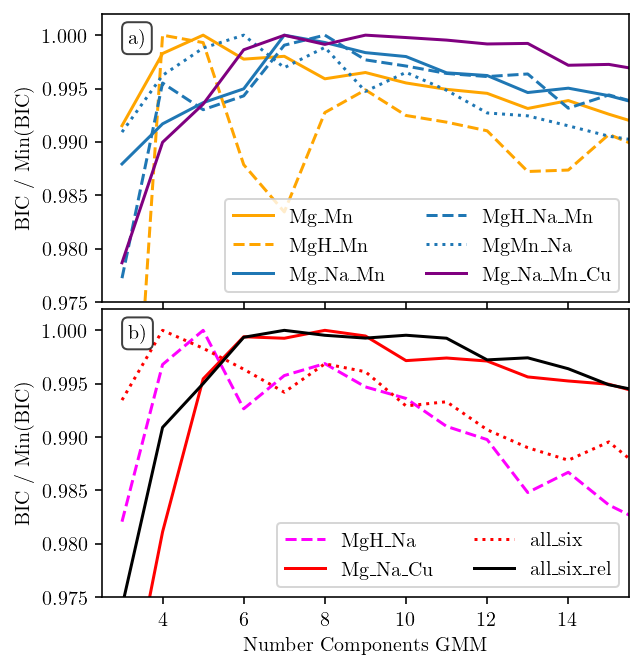

In [183]:
def plot_bic_statistics():
    f, gs = plt.subplots(2,1,figsize=(4.5,4.75),sharex=True, sharey=True)

    colors = ['orange','orange','C0','C0','C0','purple']
    style = ['solid','dashed','solid','dashed','dotted','solid']
    names = ['Mg_Mn','MgH_Mn','Mg_Na_Mn','MgH_Na_Mn','MgMn_Na','Mg_Na_Mn_Cu']
    gmms = [gmm_Mg_Mn, gmm_MgH_Mn, gmm_Mg_Na_Mn, gmm_MgH_Na_Mn, gmm_MgMn_Na, gmm_Mg_Na_Mn_Cu]

    ax=gs[0]
    ax.text(0.05,0.95,'a)',transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    for ind, (gmm, name) in enumerate(zip(gmms, names)):
        ax.plot(
            gmm['sample_n_comp'],
            gmm['sample_bic']/np.min(gmm['sample_bic']),
            c = colors[ind],
            ls = style[ind],
            label = name.replace('_','\_')
        )
    ax.set_ylabel('BIC / Min(BIC)')
    ax.legend(ncol=2)
    ax.set_xlim(2.5,15.5)
    ax.set_ylim(0.975,1.002)

    colors = ['magenta','r','r','k','k']
    style = ['dashed','solid','dotted','solid','dotted']
    names = ['MgH_Na','Mg_Na_Cu','all_six','all_six_rel']
    gmms = [
        gmm_MgH_Na,
        gmm_Mg_Na_Cu,
        gmm_MgCu_Na,
        gmm_all_six,
        gmm_all_sixb
        ]

    ax=gs[1]
    ax.text(0.05,0.95,'b)',transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    for ind, (gmm, name) in enumerate(zip(gmms, names)):
        ax.plot(
            gmm['sample_n_comp'],
            gmm['sample_bic']/np.min(gmm['sample_bic']),
            c = colors[ind],
            ls = style[ind],
            label = name.replace('_','\_')
        )
    ax.set_xlabel('Number Components GMM')
    ax.set_ylabel('BIC / Min(BIC)')
    ax.legend(ncol=2)

    plt.tight_layout(h_pad=0,w_pad=0)
    plt.savefig('bic_stats.png',dpi=200,bbox_inches='tight')

# if plot_again:
plot_bic_statistics()

In [184]:
def sample_gmm_proba(
    gmm,
    elements,
    error_limit = 0.25,
    fe_h_limit = -0.6,
    MC_size = 999
    ):

    np.random.seed(491)

    element_cuts = dict()
    element_cuts['Mg'] = (-0.3,0.7)
    element_cuts['Si'] = (-0.3,0.7)
    element_cuts['Na'] = (-0.7,0.7)
    element_cuts['Mn'] = (-0.7,0.25)
    element_cuts['Ni'] = (-0.7,0.25)
    element_cuts['Cu'] = (-1.0,0.5)

    selection = gmm['selection']
    nr_stars = np.shape(data['sobject_id'][selection])[0]
    
    if elements == ['Mg','Mn']:
        sampled_input = np.array([
            np.random.normal(
                loc = data[element+'_fe'][selection],
                scale = data['e_'+element+'_fe'][selection],
                size = (MC_size,nr_stars)
            )
            for element in elements
        ]).T

        gmm['sampled_probablity'] = np.array([np.sum(gmm['best_gmm'].predict_proba(sampled_input[nr_star]),axis=0)/MC_size for nr_star in range(nr_stars)])
    elif elements == ['MgH','Mn']:
        sampled_input = np.array([
            np.random.normal(
                loc = data['Mg_fe'][selection]+data['fe_h'][selection],
                scale = data['e_Mg_fe'][selection],
                size = (MC_size,nr_stars)
            ),
            np.random.normal(
                loc = data['Mn_fe'][selection],
                scale = data['e_Mn_fe'][selection],
                size = (MC_size,nr_stars)
            )
        ]).T

        gmm['sampled_probablity'] = np.array([np.sum(gmm['best_gmm'].predict_proba(sampled_input[nr_star]),axis=0)/MC_size for nr_star in range(nr_stars)])
    elif elements == ['MgH','Na']:
        sampled_input = np.array([
            np.random.normal(
                loc = data['Mg_fe'][selection]+data['fe_h'][selection],
                scale = data['e_Mg_fe'][selection],
                size = (MC_size,nr_stars)
            ),
            np.random.normal(
                loc = data['Na_fe'][selection],
                scale = data['e_Na_fe'][selection],
                size = (MC_size,nr_stars)
            )
        ]).T

        gmm['sampled_probablity'] = np.array([np.sum(gmm['best_gmm'].predict_proba(sampled_input[nr_star]),axis=0)/MC_size for nr_star in range(nr_stars)])
    elif elements == ['Mg','Na','Mn']:
        sampled_input = np.array([
            np.random.normal(
                loc = data['Mg_fe'][selection],
                scale = data['e_Mg_fe'][selection],
                size = (MC_size,nr_stars)
            ),
            np.random.normal(
                loc = data['Na_fe'][selection],
                scale = data['e_Na_fe'][selection],
                size = (MC_size,nr_stars)
            ),
            np.random.normal(
                loc = data['Mn_fe'][selection],
                scale = data['e_Mn_fe'][selection],
                size = (MC_size,nr_stars)
            )
        ]).T
        
        gmm['sampled_probablity'] = np.array([np.sum(gmm['best_gmm'].predict_proba(sampled_input[nr_star]),axis=0)/MC_size for nr_star in range(nr_stars)])
    elif elements == ['MgH','Na','Mn']:
        sampled_input = np.array([
            np.random.normal(
                loc = data['Mg_fe'][selection] + data['fe_h'][selection],
                scale = data['e_Mg_fe'][selection],
                size = (MC_size,nr_stars)
            ),
            np.random.normal(
                loc = data['Na_fe'][selection],
                scale = data['e_Na_fe'][selection],
                size = (MC_size,nr_stars)
            ),
            np.random.normal(
                loc = data['Mn_fe'][selection],
                scale = data['e_Mn_fe'][selection],
                size = (MC_size,nr_stars)
            )
        ]).T
        
        gmm['sampled_probablity'] = np.array([np.sum(gmm['best_gmm'].predict_proba(sampled_input[nr_star]),axis=0)/MC_size for nr_star in range(nr_stars)])

    elif elements == ['MgMn','Na']:
        elements = ['Mg','Na','Mn']
        sampled_input = np.array([
            np.random.normal(
                loc = data['Mg_fe'][selection],
                scale = data['e_Mg_fe'][selection],
                size = (MC_size,nr_stars)
            ) - np.random.normal(
                loc = data['Mn_fe'][selection],
                scale = data['e_Mn_fe'][selection],
                size = (MC_size,nr_stars)
            ),
            np.random.normal(
                loc = data['Na_fe'][selection],
                scale = data['e_Na_fe'][selection],
                size = (MC_size,nr_stars)
            )
        ]).T     
        gmm['sampled_probablity'] = np.array([np.sum(gmm['best_gmm'].predict_proba(sampled_input[nr_star]),axis=0)/MC_size for nr_star in range(nr_stars)])


    elif elements == ['MgCu','Na']:
        elements = ['Mg','Na','Cu']
        sampled_input = np.array([
            np.random.normal(
                loc = data['Mg_fe'][selection],
                scale = data['e_Mg_fe'][selection],
                size = (MC_size,nr_stars)
            ) - np.random.normal(
                loc = data['Cu_fe'][selection],
                scale = data['e_Cu_fe'][selection],
                size = (MC_size,nr_stars)
            ),
            np.random.normal(
                loc = data['Na_fe'][selection],
                scale = data['e_Na_fe'][selection],
                size = (MC_size,nr_stars)
            )
        ]).T
        
        gmm['sampled_probablity'] = np.array([np.sum(gmm['best_gmm'].predict_proba(sampled_input[nr_star]),axis=0)/MC_size for nr_star in range(nr_stars)])
    elif elements == ['Mg','Na','Mn','Cu']:
        sampled_input = np.array([
            np.random.normal(
                loc = data['Mg_fe'][selection],
                scale = data['e_Mg_fe'][selection],
                size = (MC_size,nr_stars)
            ),
            np.random.normal(
                loc = data['Na_fe'][selection],
                scale = data['e_Na_fe'][selection],
                size = (MC_size,nr_stars)
            ),
            np.random.normal(
                loc = data['Mn_fe'][selection],
                scale = data['e_Mn_fe'][selection],
                size = (MC_size,nr_stars)
            ),
            np.random.normal(
                loc = data['Cu_fe'][selection],
                scale = data['e_Cu_fe'][selection],
                size = (MC_size,nr_stars)
            )
        ]).T
        
        gmm['sampled_probablity'] = np.array([np.sum(gmm['best_gmm'].predict_proba(sampled_input[nr_star]),axis=0)/MC_size for nr_star in range(nr_stars)])
    else:
        print('I cannot deal with this element combination')

    return(gmm)

In [25]:
MC_size = 1000
# Sample with MC_size

gmm_Mg_Mn = sample_gmm_proba(
    gmm = gmm_Mg_Mn,
    elements = ['Mg','Mn'],
    MC_size = MC_size
    )
gmm_MgH_Mn = sample_gmm_proba(
    gmm = gmm_MgH_Mn,
    elements = ['MgH','Mn'],
    MC_size = MC_size
    )
gmm_MgH_Na = sample_gmm_proba(
    gmm = gmm_MgH_Na,
    elements = ['MgH','Na'],
    MC_size = MC_size
    )
gmm_Mg_Na_Mn = sample_gmm_proba(
    gmm = gmm_Mg_Na_Mn,
    elements = ['Mg','Na','Mn'],
    MC_size = MC_size
    )
gmm_MgH_Na_Mn = sample_gmm_proba(
    gmm = gmm_MgH_Na_Mn,
    elements = ['MgH','Na','Mn'],
    MC_size = MC_size
    )
gmm_MgMn_Na = sample_gmm_proba(
    gmm = gmm_MgMn_Na,
    elements = ['MgMn','Na'],
    MC_size = MC_size
    )
gmm_MgCu_Na = sample_gmm_proba(
    gmm = gmm_MgCu_Na,
    elements = ['MgCu','Na'],
    MC_size = MC_size
    )
gmm_Mg_Na_Mn_Cu = sample_gmm_proba(
    gmm = gmm_Mg_Na_Mn_Cu,
    elements = ['Mg','Na','Mn','Cu'],
    MC_size = MC_size
    )

## Overview of the individual GMMs

In [26]:
def plot_gmm_overview(names, gmms, saveas):
    f, gs = plt.subplots(9,len(names),figsize=(8.3,10.75))

    probability_threshold = 0.5

    for ind, (gmm, name) in enumerate(zip(gmms,names)):

        #if ind == len(gmms)-1:
        #    print(gmm['best_gmm'].means_)

        ranges = dict()
        ranges['Fe'] = (-2.5,-0.4)
        ranges['Mg'] = (-0.3,0.8)
        ranges['Si'] = (-0.3,0.8)
        ranges['Na'] = (-0.7,0.7)
        ranges['Mn'] = (-0.7,0.4)
        ranges['Ni'] = (-1.0,0.5)
        ranges['Cu'] = (-1.0,0.5)
        ranges['MgH'] = (-2.2,0.2)
        ranges['MgMn'] = (-0.5,1.2)
        ranges['MgCu'] = (-0.5,1.2)

        if name == 'Mg_Mn':
            components = [3,1,2,4,0][::-1]
            colors = ['orange','C0','purple','k','red'][::-1]
            label = ['Input','(Input)','Output','Output','Output','Output','Output','Output','Output']
        elif name == 'MgH_Mn':
            components = [0,4,1,2,3][::-1]
            colors = ['orange','C0','purple','k','red'][::-1]
            label = ['(Input)','Input','Output','Output','Output','Output','Output','Output','Output']
        elif name == 'MgH_Na':
            components = [1,2,3,0][::-1]
            colors = ['orange','purple','k','red'][::-1]
            label = ['Output','Output','Input','Output','Output','Output','Output','Output','Output']
        elif name == 'Mg_Na_Mn':
            components = [3,1,2,4,5,6,0][::-1]
            colors = ['orange','pink','C0','k','purple','magenta','red'][::-1]
            label = ['(Input)','(Input)','(Input)','(Input)','Output','Output','Output','Output','Output']
        elif name == 'MgMn_Na':
            components = [3,2,4,1,0][::-1]
            colors = ['orange','C0','purple','k','red'][::-1]
            label = ['(Input)','(Input)','(Input)','Input','Output','Output','Output','Output','Output']
        elif name == 'Mg_Na_Cu':
            components = [1,4,3,2,0,5][::-1]
            colors = ['orange','C0','purple','k','red','magenta'][::-1]
            label = ['Output','Output','(Input)','Output','(Input)','Output','Output','Output','Output']
        elif name == 'MgCu_Na':
            components = [3,0,2,1][::-1]
            colors = ['orange','C0','purple','red'][::-1]
            label = ['Output','Output','(Input)','Output','Input','Output','Output','Output','Output']
        else:
            components = np.arange(gmm['best_gmm'].n_components)
            colors = ['orange','C0','purple','k','red','magenta','pink','brown','blue']
            label = ['Output','Output','Output','Output','Output','Output','Output','Output','Output']

        corner_kwargs = dict(
            no_fill_contours=True,
            plot_datapoints=False,
            plot_density=False,
            #contour_kwargs = dict(linewidths=[0.2,0.5,1,2])
        )
        
        print(name,components)
        for each_ind, each_component in enumerate(components):

            # [Mg/Fe] vs. [Mn/Fe]
            ax = gs[0,ind]
            ax.set_title(name.replace('_','\_')+' ('+str(gmm['best_gmm'].n_components)+')',
                         fontsize=10,pad=15
                        )
            ax.text(0.025,0.875,label[0],transform=ax.transAxes)
            ax.set_xlabel('[Mg/Fe]')
            if ind==0:
                ax.set_ylabel('[Mn/Fe]')
            else:
                ax.set_yticks([])
            above_threshold = (
                (gmm['prediction_proba'][:,each_component] > probability_threshold) &
                (data['flag_Mg_fe'][gmm['selection']] == 0) &
                (data['flag_Mn_fe'][gmm['selection']] == 0)
            )
            corner.hist2d(
                data['Mg_fe'][gmm['selection']][above_threshold],
                data['Mn_fe'][gmm['selection']][above_threshold],  
                ax=ax,
                color=colors[each_ind],
                contour_kwargs = dict(linewidths=[0.2,0.5,1,2]),
                range=[ranges['Mg'],ranges['Mn']],
                **corner_kwargs
            )
            # [Mg/H] vs. [Mn/Fe]
            ax = gs[1,ind]
            ax.text(0.025,0.875,label[1],transform=ax.transAxes)
            ax.set_xlabel('[Mg/H]')
            if ind==0:
                ax.set_ylabel('[Mn/Fe]')
            else:
                ax.set_yticks([])
            above_threshold = (
                (gmm['prediction_proba'][:,each_component] > probability_threshold) &
                (data['flag_Mg_fe'][gmm['selection']] == 0) &
                (data['flag_Mn_fe'][gmm['selection']] == 0)
            )
            corner.hist2d(
                data['Mg_fe'][gmm['selection']][above_threshold]+data['fe_h'][gmm['selection']][above_threshold],
                data['Mn_fe'][gmm['selection']][above_threshold],  
                ax=ax,
                color=colors[each_ind],
                contour_kwargs = dict(linewidths=[0.2,0.5,1,2]),
                range=[ranges['MgH'],ranges['Mn']],
                **corner_kwargs
            )
            # [Mg/H] vs. [Na/Fe]
            ax = gs[2,ind]
            ax.text(0.025,0.875,label[2],transform=ax.transAxes)
            ax.set_xlabel('[Mg/H]')
            if ind==0:
                ax.set_ylabel('[Na/Fe]')
            else:
                ax.set_yticks([])
            above_threshold = (
                (gmm['prediction_proba'][:,each_component] > probability_threshold) &
                (data['flag_Mg_fe'][gmm['selection']] == 0) &
                (data['flag_Na_fe'][gmm['selection']] == 0)
            )
            corner.hist2d(
                data['Mg_fe'][gmm['selection']][above_threshold]+data['fe_h'][gmm['selection']][above_threshold],
                data['Na_fe'][gmm['selection']][above_threshold],  
                ax=ax,
                color=colors[each_ind],
                contour_kwargs = dict(linewidths=[0.2,0.5,1,2]),
                range=[ranges['MgH'],ranges['Na']],
                **corner_kwargs
            )
            # [Mg/Mn] vs. [Na/Fe]
            ax = gs[3,ind]
            ax.text(0.025,0.875,label[3],transform=ax.transAxes)
            ax.set_xlabel('[Na/Fe]')
            if ind==0:
                ax.set_ylabel('[Mg/Mn]')
            else:
                ax.set_yticks([])
            above_threshold = (
                (gmm['prediction_proba'][:,each_component] > probability_threshold) &
                (data['flag_Mg_fe'][gmm['selection']] == 0) &
                (data['flag_Na_fe'][gmm['selection']] == 0) &
                (data['flag_Mn_fe'][gmm['selection']] == 0)
            )
            corner.hist2d(
                data['Na_fe'][gmm['selection']][above_threshold],  
                data['Mg_fe'][gmm['selection']][above_threshold]-data['Mn_fe'][gmm['selection']][above_threshold],
                ax=ax,
                color=colors[each_ind],
                contour_kwargs = dict(linewidths=[0.2,0.5,1,2]),
                range=[ranges['Na'],ranges['MgMn']],
                **corner_kwargs
            )
            # [Mg/Cu] vs. [Na/Fe]
            ax = gs[4,ind]
            ax.text(0.025,0.875,label[4],transform=ax.transAxes)
            ax.set_xlabel('[Na/Fe]')
            if ind==0:
                ax.set_ylabel('[Mg/Cu]')
            else:
                ax.set_yticks([])
            above_threshold = (
                (gmm['prediction_proba'][:,each_component] > probability_threshold) &
                (data['flag_Mg_fe'][gmm['selection']] == 0) &
                (data['flag_Na_fe'][gmm['selection']] == 0) &
                (data['flag_Cu_fe'][gmm['selection']] == 0)
            )
            corner.hist2d(
                data['Na_fe'][gmm['selection']][above_threshold],  
                data['Mg_fe'][gmm['selection']][above_threshold]-data['Cu_fe'][gmm['selection']][above_threshold],
                ax=ax,
                color=colors[each_ind],
                contour_kwargs = dict(linewidths=[0.2,0.5,1,2]),
                range=[ranges['Na'],ranges['MgCu']],
                **corner_kwargs
            )
            # [Fe/H] vs. [Mg/Fe]
            ax = gs[5,ind]
            ax.text(0.025,0.875,label[5],transform=ax.transAxes)
            ax.set_xlabel('[Fe/H]')
            if ind==0:
                ax.set_ylabel('[Mg/Fe]')
            else:
                ax.set_yticks([])
            above_threshold = (
                (gmm['prediction_proba'][:,each_component] > probability_threshold) &
                (data['flag_Mg_fe'][gmm['selection']] == 0)
            )
            corner.hist2d(
                data['fe_h'][gmm['selection']][above_threshold],
                data['Mg_fe'][gmm['selection']][above_threshold],  
                ax=ax,
                color=colors[each_ind],
                contour_kwargs = dict(linewidths=[0.2,0.5,1,2]),
                range=[ranges['Fe'],ranges['Mg']],
                **corner_kwargs
            )
            # [Fe/H] vs. [Na/Fe]
            ax = gs[6,ind]
            ax.text(0.025,0.875,label[6],transform=ax.transAxes)
            ax.set_xlabel('[Fe/H]')
            if ind==0:
                ax.set_ylabel('[Na/Fe]')
            else:
                ax.set_yticks([])
            above_threshold = (
                (gmm['prediction_proba'][:,each_component] > probability_threshold) &
                (data['flag_Na_fe'][gmm['selection']] == 0)
            )
            corner.hist2d(
                data['fe_h'][gmm['selection']][above_threshold],
                data['Na_fe'][gmm['selection']][above_threshold],  
                ax=ax,
                color=colors[each_ind],
                contour_kwargs = dict(linewidths=[0.2,0.5,1,2]),
                range=[ranges['Fe'],ranges['Na']],
                **corner_kwargs
            )
            # [Fe/H] vs. [Mn/Fe]
            ax = gs[7,ind]
            ax.text(0.025,0.875,label[7],transform=ax.transAxes)
            ax.set_xlabel('[Fe/H]')
            if ind==0:
                ax.set_ylabel('[Mn/Fe]')
            else:
                ax.set_yticks([])
            above_threshold = (
                (gmm['prediction_proba'][:,each_component] > probability_threshold) &
                (data['flag_Mn_fe'][gmm['selection']] == 0)
            )
            corner.hist2d(
                data['fe_h'][gmm['selection']][above_threshold],
                data['Mn_fe'][gmm['selection']][above_threshold],  
                ax=ax,
                color=colors[each_ind],
                contour_kwargs = dict(linewidths=[0.2,0.5,1,2]),
                range=[ranges['Fe'],ranges['Mn']],
                **corner_kwargs
            )
            # [Fe/H] vs. [Cu/Fe]
            ax = gs[8,ind]
            ax.text(0.025,0.875,label[8],transform=ax.transAxes)
            ax.set_xlabel('[Fe/H]')
            if ind==0:
                ax.set_ylabel('[Cu/Fe]')
            else:
                ax.set_yticks([])
            above_threshold = (
                (gmm['prediction_proba'][:,each_component] > probability_threshold) &
                (data['flag_Mn_fe'][gmm['selection']] == 0)
            )
            corner.hist2d(
                data['fe_h'][gmm['selection']][above_threshold],
                data['Cu_fe'][gmm['selection']][above_threshold],  
                ax=ax,
                color=colors[each_ind],
                contour_kwargs = dict(linewidths=[0.2,0.5,1,2]),
                range=[ranges['Fe'],ranges['Cu']],
                **corner_kwargs
            )

    plt.tight_layout(h_pad=0, w_pad=0)
    plt.savefig(saveas,dpi=200,bbox_inches='tight')
    plt.show()
    plt.close()

In [27]:
def plot_gmm_overview_2parts(
    names, 
    gmms, 
    saveas,
    probability_threshold = 0.5
    ):
    
    ranges = dict()
    ranges['Fe'] = (-2.5,-0.4)
    ranges['Mg'] = (-0.3,0.8)
    ranges['Si'] = (-0.3,0.8)
    ranges['Na'] = (-0.7,0.7)
    ranges['Mn'] = (-0.7,0.4)
    ranges['Ni'] = (-0.98,0.48)
    ranges['Cu'] = (-0.98,0.48)
    ranges['MgH'] = (-2.2,0.2)
    ranges['MgMn'] = (-0.4,1.2)
    ranges['MgCu'] = (-0.4,1.2)

    f, gs = plt.subplots(5,len(names),figsize=(8.3,8))

    for ind, (gmm, name) in enumerate(zip(gmms,names)):
        if name == 'Mg_Mn':
            components = [3,1,2,4,0][::-1]
            colors = ['orange','C0','purple','k','red'][::-1]
            label = ['Input','(Input)','','','','','','','']
        elif name == 'MgH_Mn':
            components = [0,4,1,2,3][::-1]
            colors = ['orange','C0','purple','k','red'][::-1]
            label = ['(Input)','Input','','','','','','','']
        elif name == 'MgH_Na':
            components = [1,2,3,0][::-1]
            colors = ['orange','purple','k','red'][::-1]
            label = ['','','Input','','','','','','']
        elif name == 'Mg_Na_Mn':
            components = [3,1,2,4,5,6,0][::-1]
            colors = ['orange','pink','C0','k','purple','magenta','red'][::-1]
            label = ['(Input)','(Input)','(Input)','(Input)','','','','','']
        elif name == 'MgMn_Na':
            components = [3,2,4,1,0][::-1]
            colors = ['orange','C0','purple','k','red'][::-1]
            label = ['(Input)','(Input)','(Input)','Input','','','','','']
        elif name == 'Mg_Na_Cu':
            components = [1,4,3,2,0,5][::-1]
            colors = ['orange','C0','purple','k','red','magenta'][::-1]
            label = ['','','(Input)','','(Input)','','','','']
        elif name == 'MgCu_Na':
            components = [3,0,2,1][::-1]
            colors = ['orange','C0','purple','red'][::-1]
            label = ['','','(Input)','','Input','','','','']
        else:
            components = np.arange(gmm['best_gmm'].n_components)
            colors = ['orange','C0','purple','k','red','magenta','pink','brown','blue']
            label = ['','','','','','','','','']

        corner_kwargs = dict(
            no_fill_contours=True,
            plot_datapoints=False,
            plot_density=False,
            #contour_kwargs = dict(linewidths=[0.2,0.5,1,2])
        )
        
        print(name,components)
        for each_ind, each_component in enumerate(components):
            # [Mg/Fe] vs. [Mn/Fe]
            ax = gs[0,ind]
            ax.set_title(name.replace('_','\_')+' ('+str(gmm['best_gmm'].n_components)+')',
                         fontsize=12,pad=15
                        )
            ax.text(0.025,0.875,label[0],transform=ax.transAxes)
            ax.set_xlabel('[Mg/Fe]')
            if ind==0:
                ax.set_ylabel('[Mn/Fe]')
            else:
                ax.set_yticks([])
            above_threshold = (
                (gmm['prediction_proba'][:,each_component] > probability_threshold) &
                (data['flag_Mg_fe'][gmm['selection']] == 0) &
                (data['flag_Mn_fe'][gmm['selection']] == 0)
            )
            corner.hist2d(
                data['Mg_fe'][gmm['selection']][above_threshold],
                data['Mn_fe'][gmm['selection']][above_threshold],  
                ax=ax,
                color=colors[each_ind],
                contour_kwargs = dict(linewidths=[0.2,0.5,1,2]),
                weights = gmm['prediction_proba'][:,each_component][above_threshold],
                range=[ranges['Mg'],ranges['Mn']],
                **corner_kwargs
            )
            # [Mg/H] vs. [Mn/Fe]
            ax = gs[1,ind]
            ax.text(0.025,0.875,label[1],transform=ax.transAxes)
            ax.set_xlabel('[Mg/H]')
            ax.set_xticks([-2,-1,0])
            if ind==0:
                ax.set_ylabel('[Mn/Fe]')
            else:
                ax.set_yticks([])
            above_threshold = (
                (gmm['prediction_proba'][:,each_component] > probability_threshold) &
                (data['flag_Mg_fe'][gmm['selection']] == 0) &
                (data['flag_Mn_fe'][gmm['selection']] == 0)
            )
            corner.hist2d(
                data['Mg_fe'][gmm['selection']][above_threshold]+data['fe_h'][gmm['selection']][above_threshold],
                data['Mn_fe'][gmm['selection']][above_threshold],  
                ax=ax,
                color=colors[each_ind],
                contour_kwargs = dict(linewidths=[0.2,0.5,1,2]),
                weights = gmm['prediction_proba'][:,each_component][above_threshold],
                range=[ranges['MgH'],ranges['Mn']],
                **corner_kwargs
            )
            # [Mg/H] vs. [Na/Fe]
            ax = gs[2,ind]
            ax.text(0.025,0.875,label[2],transform=ax.transAxes)
            ax.set_xlabel('[Mg/H]')
            ax.set_xticks([-2,-1,0])
            if ind==0:
                ax.set_ylabel('[Na/Fe]')
            else:
                ax.set_yticks([])
            above_threshold = (
                (gmm['prediction_proba'][:,each_component] > probability_threshold) &
                (data['flag_Mg_fe'][gmm['selection']] == 0) &
                (data['flag_Na_fe'][gmm['selection']] == 0)
            )
            corner.hist2d(
                data['Mg_fe'][gmm['selection']][above_threshold]+data['fe_h'][gmm['selection']][above_threshold],
                data['Na_fe'][gmm['selection']][above_threshold],  
                ax=ax,
                color=colors[each_ind],
                contour_kwargs = dict(linewidths=[0.2,0.5,1,2]),
                weights = gmm['prediction_proba'][:,each_component][above_threshold],
                range=[ranges['MgH'],ranges['Na']],
                **corner_kwargs
            )
            # [Mg/Mn] vs. [Na/Fe]
            ax = gs[3,ind]
            ax.text(0.025,0.875,label[3],transform=ax.transAxes)
            ax.set_xlabel('[Na/Fe]')
            if ind==0:
                ax.set_ylabel('[Mg/Mn]')
                ax.set_yticks([0,0.5,1])
            else:
                ax.set_yticks([])
            above_threshold = (
                (gmm['prediction_proba'][:,each_component] > probability_threshold) &
                (data['flag_Mg_fe'][gmm['selection']] == 0) &
                (data['flag_Na_fe'][gmm['selection']] == 0) &
                (data['flag_Mn_fe'][gmm['selection']] == 0)
            )
            corner.hist2d(
                data['Na_fe'][gmm['selection']][above_threshold],  
                data['Mg_fe'][gmm['selection']][above_threshold]-data['Mn_fe'][gmm['selection']][above_threshold],
                ax=ax,
                color=colors[each_ind],
                contour_kwargs = dict(linewidths=[0.2,0.5,1,2]),
                weights = gmm['prediction_proba'][:,each_component][above_threshold],
                range=[ranges['Na'],ranges['MgMn']],
                **corner_kwargs
            )
            # [Mg/Cu] vs. [Na/Fe]
            ax = gs[4,ind]
            ax.text(0.025,0.875,label[4],transform=ax.transAxes)
            ax.set_xlabel('[Na/Fe]')
            if ind==0:
                ax.set_ylabel('[Mg/Cu]')
                ax.set_yticks([0,0.5,1])
            else:
                ax.set_yticks([])
            above_threshold = (
                (gmm['prediction_proba'][:,each_component] > probability_threshold) &
                (data['flag_Mg_fe'][gmm['selection']] == 0) &
                (data['flag_Na_fe'][gmm['selection']] == 0) &
                (data['flag_Cu_fe'][gmm['selection']] == 0)
            )
            corner.hist2d(
                data['Na_fe'][gmm['selection']][above_threshold],  
                data['Mg_fe'][gmm['selection']][above_threshold]-data['Cu_fe'][gmm['selection']][above_threshold],
                ax=ax,
                color=colors[each_ind],
                contour_kwargs = dict(linewidths=[0.2,0.5,1,2]),
                weights = gmm['prediction_proba'][:,each_component][above_threshold],
                range=[ranges['Na'],ranges['MgCu']],
                **corner_kwargs
            )
            

    plt.tight_layout(h_pad=0.5,w_pad=0)
    plt.savefig(saveas+'_part1.png',dpi=200,bbox_inches='tight')
    plt.show()
    plt.close()
                
    f, gs = plt.subplots(5,len(names),figsize=(8.3,8))

    for ind, (gmm, name) in enumerate(zip(gmms,names)):
        if name == 'Mg_Mn':
            components = [3,1,2,4,0][::-1]
            colors = ['orange','C0','purple','k','red'][::-1]
            label = ['Input','(Input)','','','','','','','']
        elif name == 'MgH_Mn':
            components = [0,4,1,2,3][::-1]
            colors = ['orange','C0','purple','k','red'][::-1]
            label = ['(Input)','Input','','','','','','','']
        elif name == 'MgH_Na':
            components = [1,2,3,0][::-1]
            colors = ['orange','purple','k','red'][::-1]
            label = ['','','Input','','','','','','']
        elif name == 'Mg_Na_Mn':
            components = [3,1,2,4,5,6,0][::-1]
            colors = ['orange','pink','C0','k','purple','magenta','red'][::-1]
            label = ['(Input)','(Input)','(Input)','(Input)','','','','','']
        elif name == 'MgMn_Na':
            components = [3,2,4,1,0][::-1]
            colors = ['orange','C0','purple','k','red'][::-1]
            label = ['(Input)','(Input)','(Input)','Input','','','','','']
        elif name == 'Mg_Na_Cu':
            components = [1,4,3,2,0,5][::-1]
            colors = ['orange','C0','purple','k','red','magenta'][::-1]
            label = ['','','(Input)','','(Input)','','','','']
        elif name == 'MgCu_Na':
            components = [3,0,2,1][::-1]
            colors = ['orange','C0','purple','red'][::-1]
            label = ['','','(Input)','','Input','','','','']
        else:
            components = np.arange(gmm['best_gmm'].n_components)
            colors = ['orange','C0','purple','k','red','magenta','pink','brown','blue']
            label = ['','','','','','','','','']

        corner_kwargs = dict(
            no_fill_contours=True,
            plot_datapoints=False,
            plot_density=False,
            #contour_kwargs = dict(linewidths=[0.2,0.5,1,2])
        )
        
        print(name,components)
        for each_ind, each_component in enumerate(components):
            
            # [Mg/H] vs. [Mg/Fe]
            ax = gs[0,ind]
            ax.set_title(name.replace('_','\_')+' ('+str(gmm['best_gmm'].n_components)+')',
                         fontsize=12,pad=15
                        )
            ax.text(0.025,0.875,'(Input)',transform=ax.transAxes)
            ax.set_xlabel('[Mg/H]')
            if ind==0:
                ax.set_ylabel('[Mg/Fe]')
            else:
                ax.set_yticks([])
            above_threshold = (
                (gmm['prediction_proba'][:,each_component] > probability_threshold) &
                (data['flag_Mg_fe'][gmm['selection']] == 0)
            )
            corner.hist2d(
                data['Mg_fe'][gmm['selection']][above_threshold]+data['fe_h'][gmm['selection']][above_threshold],  
                data['Mg_fe'][gmm['selection']][above_threshold], 
                ax=ax,
                color=colors[each_ind],
                contour_kwargs = dict(linewidths=[0.2,0.5,1,2]),
                weights = gmm['prediction_proba'][:,each_component][above_threshold],
                range=[ranges['MgH'],ranges['Mg']],
                **corner_kwargs
            )
            # [Fe/H] vs. [Mg/Fe]
            ax = gs[1,ind]
            ax.text(0.025,0.875,label[5],transform=ax.transAxes)
            ax.set_xlabel('[Fe/H]')
            if ind==0:
                ax.set_ylabel('[Mg/Fe]')
            else:
                ax.set_yticks([])
            above_threshold = (
                (gmm['prediction_proba'][:,each_component] > probability_threshold) &
                (data['flag_Mg_fe'][gmm['selection']] == 0)
            )
            corner.hist2d(
                data['fe_h'][gmm['selection']][above_threshold],
                data['Mg_fe'][gmm['selection']][above_threshold],  
                ax=ax,
                color=colors[each_ind],
                contour_kwargs = dict(linewidths=[0.2,0.5,1,2]),
                weights = gmm['prediction_proba'][:,each_component][above_threshold],
                range=[ranges['Fe'],ranges['Mg']],
                **corner_kwargs
            )
            # [Fe/H] vs. [Na/Fe]
            ax = gs[2,ind]
            ax.text(0.025,0.875,label[6],transform=ax.transAxes)
            ax.set_xlabel('[Fe/H]')
            if ind==0:
                ax.set_ylabel('[Na/Fe]')
            else:
                ax.set_yticks([])
            above_threshold = (
                (gmm['prediction_proba'][:,each_component] > probability_threshold) &
                (data['flag_Na_fe'][gmm['selection']] == 0)
            )
            corner.hist2d(
                data['fe_h'][gmm['selection']][above_threshold],
                data['Na_fe'][gmm['selection']][above_threshold],  
                ax=ax,
                color=colors[each_ind],
                contour_kwargs = dict(linewidths=[0.2,0.5,1,2]),
                weights = gmm['prediction_proba'][:,each_component][above_threshold],
                range=[ranges['Fe'],ranges['Na']],
                **corner_kwargs
            )
            # [Fe/H] vs. [Mn/Fe]
            ax = gs[3,ind]
            ax.text(0.025,0.875,label[7],transform=ax.transAxes)
            ax.set_xlabel('[Fe/H]')
            if ind==0:
                ax.set_ylabel('[Mn/Fe]')
            else:
                ax.set_yticks([])
            above_threshold = (
                (gmm['prediction_proba'][:,each_component] > probability_threshold) &
                (data['flag_Mn_fe'][gmm['selection']] == 0)
            )
            corner.hist2d(
                data['fe_h'][gmm['selection']][above_threshold],
                data['Mn_fe'][gmm['selection']][above_threshold],  
                ax=ax,
                color=colors[each_ind],
                contour_kwargs = dict(linewidths=[0.2,0.5,1,2]),
                range=[ranges['Fe'],ranges['Mn']],
                **corner_kwargs
            )
            # [Fe/H] vs. [Cu/Fe]
            ax = gs[4,ind]
            ax.text(0.025,0.875,label[8],transform=ax.transAxes)
            ax.set_xlabel('[Fe/H]')
            if ind==0:
                ax.set_ylabel('[Cu/Fe]')
            else:
                ax.set_yticks([])
            above_threshold = (
                (gmm['prediction_proba'][:,each_component] > probability_threshold) &
                (data['flag_Mn_fe'][gmm['selection']] == 0)
            )
            corner.hist2d(
                data['fe_h'][gmm['selection']][above_threshold],
                data['Cu_fe'][gmm['selection']][above_threshold],  
                ax=ax,
                color=colors[each_ind],
                contour_kwargs = dict(linewidths=[0.2,0.5,1,2]),
                weights = gmm['prediction_proba'][:,each_component][above_threshold],
                range=[ranges['Fe'],ranges['Cu']],
                **corner_kwargs
            )

    plt.tight_layout(h_pad=0.5,w_pad=0)
    plt.savefig(saveas+'_part2.png',dpi=200,bbox_inches='tight')
    plt.show()
    plt.close()

In [83]:
def plot_gmm_overview_2parts_sampled(
    names, 
    gmms, 
    saveas,
    probability_threshold = 0.5,
    plot_rest_grey = True
    ):

    ranges = dict()
    ranges['Fe'] = (-2.5,-0.4)
    ranges['Mg'] = (-0.3,0.8)
    ranges['Si'] = (-0.3,0.8)
    ranges['Na'] = (-0.7,0.7)
    ranges['Mn'] = (-0.7,0.4)
    ranges['Ni'] = (-0.98,0.48)
    ranges['Cu'] = (-0.98,0.48)
    ranges['MgH'] = (-2.2,0.2)
    ranges['MgMn'] = (-0.4,1.2)
    ranges['MgCu'] = (-0.4,1.2)

    f, gs = plt.subplots(5,len(names),figsize=(8.3,8))

    c_accreted1 = 'orange'
    c_accreted2 = 'darkorange'
    c_intermediate = 'C0'
    c_lowalphadisk = 'red'
    c_highalpha1 = 'purple'
    c_highalpha2 = 'k'
    c_highalpha3 = 'magenta'
    c_highalpha4 = 'pink'
    c_rest = 'lightgrey'
    
    for ind, (gmm, name) in enumerate(zip(gmms,names)):
        if name == 'Mg_Mn':
            components = [1,2,3,0,4][::-1]
            colors = [c_accreted1,c_intermediate,c_highalpha1,c_highalpha2,c_lowalphadisk][::-1]
            label = ['Input','(Input)','','','','','','','']
        elif name == 'MgH_Mn':
            components = [2,1,0,3][::-1]
            colors = [c_accreted1,c_accreted2,c_highalpha1,c_highalpha2][::-1]
            if plot_rest_grey:
                colors = [c_accreted1,c_accreted2,c_rest,c_rest][::-1]
            label = ['(Input)','Input','','','','','','','']
        elif name == 'MgH_Na':
            components = [2,4,3,0,1][::-1]
            colors = [c_accreted1,c_accreted2,c_intermediate,c_highalpha1,c_highalpha2][::-1]
            if plot_rest_grey:
                colors = [c_accreted1,c_accreted2,c_intermediate,c_rest,c_rest][::-1]
            label = ['','','Input','','','','','','']
        elif name == 'Mg_Na_Mn':
            components = [3,1,0,4,2,6,5][::-1]
            colors = [c_accreted1,c_intermediate,c_highalpha1,c_highalpha2,c_highalpha3,c_highalpha4,c_lowalphadisk][::-1]
            if plot_rest_grey:
                colors = [c_accreted1,c_intermediate,c_rest,c_rest,c_highalpha3,c_highalpha4,c_lowalphadisk][::-1]
            label = ['(Input)','(Input)','(Input)','(Input)','','','','','']
        elif name == 'MgH_Na_Mn':
            components = [1,4,6,0,2,3,7,5][::-1]
            colors = [c_accreted1,c_accreted2,c_intermediate,c_highalpha1,c_highalpha2,c_highalpha3,c_highalpha4,c_lowalphadisk][::-1]
            if plot_rest_grey:
                colors = [c_accreted1,c_accreted2,c_intermediate,c_rest,c_rest,c_rest,c_rest,c_rest][::-1]
            label = ['(Input)','(Input)','(Input)','(Input)','','','','','']
        elif name == 'MgMn_Na':
            components = [4,3,2,0,1,5][::-1]
            colors = [c_accreted1,c_intermediate,c_highalpha1,c_highalpha2,c_highalpha3,c_lowalphadisk][::-1]
            #if plot_rest_grey:
            #    colors = [c_accreted1,c_intermediate,c_rest,c_rest,c_rest,c_rest][::-1]
            label = ['(Input)','(Input)','(Input)','Input','','','','','']
        elif name == 'MgCu_Na':
            components = [2,1,0,3][::-1]
            colors = [c_accreted1,c_intermediate,c_highalpha1,c_lowalphadisk][::-1]
            label = ['','','(Input)','','Input','','','','']
        else:
            components = np.arange(gmm['best_gmm'].n_components)
            colors = ['orange','C0','purple','k','red','magenta','pink','brown','blue']
            label = ['','','','','','','','','']

        corner_kwargs = dict(
            no_fill_contours=True,
            plot_datapoints=False,
            plot_density=False
            #contour_kwargs = dict(linewidths=[0.2,0.5,1,2])
        )
        
        print(name,components)
        for each_ind, each_component in enumerate(components):
            # [Mg/Fe] vs. [Mn/Fe]
            ax = gs[0,ind]
            ax.set_title(name.replace('_','\_')+' ('+str(gmm['best_gmm'].n_components)+')',
                         fontsize=12,pad=15
                        )
            ax.text(0.025,0.875,label[0],transform=ax.transAxes)
            ax.set_xlabel('[Mg/Fe]')
            if ind==0:
                ax.set_ylabel('[Mn/Fe]')
            else:
                ax.set_yticks([])
            above_threshold = (
                (gmm['sampled_probablity'][:,each_component] > probability_threshold) &
                (data['flag_Mg_fe'][gmm['selection']] == 0) &
                (data['flag_Mn_fe'][gmm['selection']] == 0)
            )
            corner.hist2d(
                data['Mg_fe'][gmm['selection']][above_threshold],
                data['Mn_fe'][gmm['selection']][above_threshold],  
                ax=ax,
                color=colors[each_ind],
                contour_kwargs = dict(linewidths=[0.2,0.5,1,2]),
                bins = (
                    np.linspace(ranges['Mg'][0],ranges['Mg'][1],20),
                    np.linspace(ranges['Mn'][0],ranges['Mn'][1],20)
                ),
                weights = gmm['sampled_probablity'][:,each_component][above_threshold],
                range=[ranges['Mg'],ranges['Mn']],
                **corner_kwargs
            )
            # [Mg/H] vs. [Mn/Fe]
            ax = gs[1,ind]
            ax.text(0.025,0.875,label[1],transform=ax.transAxes)
            ax.set_xlabel('[Mg/H]')
            ax.set_xticks([-2,-1,0])
            if ind==0:
                ax.set_ylabel('[Mn/Fe]')
            else:
                ax.set_yticks([])
            above_threshold = (
                (gmm['sampled_probablity'][:,each_component] > probability_threshold) &
                (data['flag_Mg_fe'][gmm['selection']] == 0) &
                (data['flag_Mn_fe'][gmm['selection']] == 0)
            )
            corner.hist2d(
                data['Mg_fe'][gmm['selection']][above_threshold]+data['fe_h'][gmm['selection']][above_threshold],
                data['Mn_fe'][gmm['selection']][above_threshold],  
                ax=ax,
                color=colors[each_ind],
                contour_kwargs = dict(linewidths=[0.2,0.5,1,2]),
                bins = (
                    np.linspace(ranges['MgH'][0],ranges['MgH'][1],20),
                    np.linspace(ranges['Mn'][0],ranges['Mn'][1],20)
                ),
                weights = gmm['sampled_probablity'][:,each_component][above_threshold],
                range=[ranges['MgH'],ranges['Mn']],
                **corner_kwargs
            )
            # [Mg/H] vs. [Na/Fe]
            ax = gs[2,ind]
            ax.text(0.025,0.875,label[2],transform=ax.transAxes)
            ax.set_xlabel('[Mg/H]')
            ax.set_xticks([-2,-1,0])
            if ind==0:
                ax.set_ylabel('[Na/Fe]')
            else:
                ax.set_yticks([])
            above_threshold = (
                (gmm['sampled_probablity'][:,each_component] > probability_threshold) &
                (data['flag_Mg_fe'][gmm['selection']] == 0) &
                (data['flag_Na_fe'][gmm['selection']] == 0)
            )
            corner.hist2d(
                data['Mg_fe'][gmm['selection']][above_threshold]+data['fe_h'][gmm['selection']][above_threshold],
                data['Na_fe'][gmm['selection']][above_threshold],  
                ax=ax,
                color=colors[each_ind],
                contour_kwargs = dict(linewidths=[0.2,0.5,1,2]),
                bins = (
                    np.linspace(ranges['MgH'][0],ranges['MgH'][1],20),
                    np.linspace(ranges['Na'][0],ranges['Na'][1],20)
                ),
                weights = gmm['sampled_probablity'][:,each_component][above_threshold],
                range=[ranges['MgH'],ranges['Na']],
                **corner_kwargs
            )
            # [Mg/Mn] vs. [Na/Fe]
            ax = gs[3,ind]
            ax.text(0.025,0.875,label[3],transform=ax.transAxes)
            ax.set_xlabel('[Na/Fe]')
            if ind==0:
                ax.set_ylabel('[Mg/Mn]')
                ax.set_yticks([0,0.5,1])
            else:
                ax.set_yticks([])
            above_threshold = (
                (gmm['sampled_probablity'][:,each_component] > probability_threshold) &
                (data['flag_Mg_fe'][gmm['selection']] == 0) &
                (data['flag_Na_fe'][gmm['selection']] == 0) &
                (data['flag_Mn_fe'][gmm['selection']] == 0)
            )
            corner.hist2d(
                data['Na_fe'][gmm['selection']][above_threshold],
                data['Mg_fe'][gmm['selection']][above_threshold]-data['Mn_fe'][gmm['selection']][above_threshold],
                ax=ax,
                color=colors[each_ind],
                contour_kwargs = dict(linewidths=[0.2,0.5,1,2]),
                bins = (
                    np.linspace(ranges['Na'][0],ranges['Na'][1],20),
                    np.linspace(ranges['MgMn'][0],ranges['MgMn'][1],20)
                ),
                weights = gmm['sampled_probablity'][:,each_component][above_threshold],
                range=[ranges['Na'],ranges['MgMn']],
                **corner_kwargs
            )
            # [Mg/Cu] vs. [Na/Fe]
            ax = gs[4,ind]
            ax.text(0.025,0.875,label[4],transform=ax.transAxes)
            ax.set_xlabel('[Na/Fe]')
            if ind==0:
                ax.set_ylabel('[Mg/Cu]')
                ax.set_yticks([0,0.5,1])
            else:
                ax.set_yticks([])
            above_threshold = (
                (gmm['sampled_probablity'][:,each_component] > probability_threshold) &
                (data['flag_Mg_fe'][gmm['selection']] == 0) &
                (data['flag_Na_fe'][gmm['selection']] == 0) &
                (data['flag_Cu_fe'][gmm['selection']] == 0)
            )
            corner.hist2d(
                data['Na_fe'][gmm['selection']][above_threshold],  
                data['Mg_fe'][gmm['selection']][above_threshold]-data['Cu_fe'][gmm['selection']][above_threshold],
                ax=ax,
                color=colors[each_ind],
                contour_kwargs = dict(linewidths=[0.2,0.5,1,2]),
                bins = (
                    np.linspace(ranges['Na'][0],ranges['Na'][1],20),
                    np.linspace(ranges['MgCu'][0],ranges['MgCu'][1],20)
                ),
                weights = gmm['sampled_probablity'][:,each_component][above_threshold],
                range=[ranges['Na'],ranges['MgCu']],
                **corner_kwargs
            )
            

    plt.tight_layout(h_pad=0.5,w_pad=0)
    plt.savefig(saveas+'_part1.png',dpi=250,bbox_inches='tight')
    plt.show()
    plt.close()
                
    f, gs = plt.subplots(5,len(names),figsize=(8.3,8))

    for ind, (gmm, name) in enumerate(zip(gmms,names)):
        if name == 'Mg_Mn':
            components = [1,2,3,0,4][::-1]
            colors = [c_accreted1,c_intermediate,c_highalpha1,c_highalpha2,c_lowalphadisk][::-1]
            label = ['Input','(Input)','','','','','','','']
        elif name == 'MgH_Mn':
            components = [2,1,0,3][::-1]
            colors = [c_accreted1,c_accreted2,c_highalpha1,c_highalpha2][::-1]
            if plot_rest_grey:
                colors = [c_accreted1,c_accreted2,c_rest,c_rest][::-1]
            label = ['(Input)','Input','','','','','','','']
        elif name == 'MgH_Na':
            components = [2,4,3,0,1][::-1]
            colors = [c_accreted1,c_accreted2,c_intermediate,c_highalpha1,c_highalpha2][::-1]
            if plot_rest_grey:
                colors = [c_accreted1,c_accreted2,c_intermediate,c_rest,c_rest][::-1]
            label = ['','','Input','','','','','','']
        elif name == 'Mg_Na_Mn':
            components = [3,1,0,4,2,6,5][::-1]
            colors = [c_accreted1,c_intermediate,c_highalpha1,c_highalpha2,c_highalpha3,c_highalpha4,c_lowalphadisk][::-1]
            if plot_rest_grey:
                colors = [c_accreted1,c_intermediate,c_rest,c_rest,c_highalpha3,c_highalpha4,c_lowalphadisk][::-1]
            label = ['(Input)','(Input)','(Input)','(Input)','','','','','']
        elif name == 'MgH_Na_Mn':
            components = [1,4,6,0,2,3,7,5][::-1]
            colors = [c_accreted1,c_accreted2,c_intermediate,c_highalpha1,c_highalpha2,c_highalpha3,c_highalpha4,c_lowalphadisk][::-1]
            if plot_rest_grey:
                colors = [c_accreted1,c_accreted2,c_intermediate,c_rest,c_rest,c_rest,c_rest,c_rest][::-1]
            label = ['(Input)','(Input)','(Input)','(Input)','','','','','']
        elif name == 'MgMn_Na':
            components = [4,3,2,0,1,5][::-1]
            colors = [c_accreted1,c_intermediate,c_highalpha1,c_highalpha2,c_highalpha3,c_lowalphadisk][::-1]
            #if plot_rest_grey:
            #    colors = [c_accreted1,c_intermediate,c_rest,c_rest,c_rest,c_rest][::-1]
            label = ['(Input)','(Input)','(Input)','Input','','','','','']
        elif name == 'MgCu_Na':
            components = [2,1,0,3][::-1]
            colors = [c_accreted1,c_intermediate,c_highalpha1,c_lowalphadisk][::-1]
            label = ['','','(Input)','','Input','','','','']
        else:
            components = np.arange(gmm['best_gmm'].n_components)
            colors = ['orange','C0','purple','k','red','magenta','pink','brown','blue']
            label = ['','','','','','','','','']

        corner_kwargs = dict(
            no_fill_contours=True,
            plot_datapoints=False,
            plot_density=False,
            #contour_kwargs = dict(linewidths=[0.2,0.5,1,2])
        )
        
        print(name,components)
        for each_ind, each_component in enumerate(components):
            
            # [Mg/H] vs. [Mg/Fe]
            ax = gs[0,ind]
            ax.set_title(name.replace('_','\_')+' ('+str(gmm['best_gmm'].n_components)+')',
                         fontsize=12,pad=15
                        )
            ax.text(0.025,0.875,'(Input)',transform=ax.transAxes)
            ax.set_xlabel('[Mg/H]')
            if ind==0:
                ax.set_ylabel('[Mg/Fe]')
            else:
                ax.set_yticks([])
            above_threshold = (
                (gmm['sampled_probablity'][:,each_component] > probability_threshold) &
                (data['flag_Mg_fe'][gmm['selection']] == 0)
            )
            corner.hist2d(
                data['Mg_fe'][gmm['selection']][above_threshold]+data['fe_h'][gmm['selection']][above_threshold],  
                data['Mg_fe'][gmm['selection']][above_threshold], 
                ax=ax,
                color=colors[each_ind],
                contour_kwargs = dict(linewidths=[0.2,0.5,1,2]),
                weights = gmm['sampled_probablity'][:,each_component][above_threshold],
                range=[ranges['MgH'],ranges['Mg']],
                **corner_kwargs
            )
            # [Fe/H] vs. [Mg/Fe]
            ax = gs[1,ind]
            ax.text(0.025,0.875,label[5],transform=ax.transAxes)
            ax.set_xlabel('[Fe/H]')
            if ind==0:
                ax.set_ylabel('[Mg/Fe]')
            else:
                ax.set_yticks([])
            above_threshold = (
                (gmm['sampled_probablity'][:,each_component] > probability_threshold) &
                (data['flag_Mg_fe'][gmm['selection']] == 0)
            )
            corner.hist2d(
                data['fe_h'][gmm['selection']][above_threshold],
                data['Mg_fe'][gmm['selection']][above_threshold],  
                ax=ax,
                color=colors[each_ind],
                contour_kwargs = dict(linewidths=[0.2,0.5,1,2]),
                weights = gmm['sampled_probablity'][:,each_component][above_threshold],
                range=[ranges['Fe'],ranges['Mg']],
                **corner_kwargs
            )
            # [Fe/H] vs. [Na/Fe]
            ax = gs[2,ind]
            ax.text(0.025,0.875,label[6],transform=ax.transAxes)
            ax.set_xlabel('[Fe/H]')
            if ind==0:
                ax.set_ylabel('[Na/Fe]')
            else:
                ax.set_yticks([])
            above_threshold = (
                (gmm['sampled_probablity'][:,each_component] > probability_threshold) &
                (data['flag_Na_fe'][gmm['selection']] == 0)
            )
            corner.hist2d(
                data['fe_h'][gmm['selection']][above_threshold],
                data['Na_fe'][gmm['selection']][above_threshold],  
                ax=ax,
                color=colors[each_ind],
                contour_kwargs = dict(linewidths=[0.2,0.5,1,2]),
                weights = gmm['sampled_probablity'][:,each_component][above_threshold],
                range=[ranges['Fe'],ranges['Na']],
                **corner_kwargs
            )
            # [Fe/H] vs. [Mn/Fe]
            ax = gs[3,ind]
            ax.text(0.025,0.875,label[7],transform=ax.transAxes)
            ax.set_xlabel('[Fe/H]')
            if ind==0:
                ax.set_ylabel('[Mn/Fe]')
            else:
                ax.set_yticks([])
            above_threshold = (
                (gmm['sampled_probablity'][:,each_component] > probability_threshold) &
                (data['flag_Mn_fe'][gmm['selection']] == 0)
            )
            corner.hist2d(
                data['fe_h'][gmm['selection']][above_threshold],
                data['Mn_fe'][gmm['selection']][above_threshold],  
                ax=ax,
                color=colors[each_ind],
                contour_kwargs = dict(linewidths=[0.2,0.5,1,2]),
                weights = gmm['sampled_probablity'][:,each_component][above_threshold],
                range=[ranges['Fe'],ranges['Mn']],
                **corner_kwargs
            )
            # [Fe/H] vs. [Cu/Fe]
            ax = gs[4,ind]
            ax.text(0.025,0.875,label[8],transform=ax.transAxes)
            ax.set_xlabel('[Fe/H]')
            if ind==0:
                ax.set_ylabel('[Cu/Fe]')
            else:
                ax.set_yticks([])
            above_threshold = (
                (gmm['sampled_probablity'][:,each_component] > probability_threshold) &
                (data['flag_Mn_fe'][gmm['selection']] == 0)
            )
            corner.hist2d(
                data['fe_h'][gmm['selection']][above_threshold],
                data['Cu_fe'][gmm['selection']][above_threshold],  
                ax=ax,
                color=colors[each_ind],
                contour_kwargs = dict(linewidths=[0.2,0.5,1,2]),
                weights = gmm['sampled_probablity'][:,each_component][above_threshold],
                range=[ranges['Fe'],ranges['Cu']],
                **corner_kwargs
            )

    plt.tight_layout(h_pad=0.5,w_pad=0)
    plt.savefig(saveas+'_part2.png',dpi=250,bbox_inches='tight')
    plt.show()
    plt.close()

Mg_Mn [4, 0, 3, 2, 1]
MgH_Mn [3, 0, 1, 2]
Mg_Na_Mn [5, 6, 2, 4, 0, 1, 3]
MgH_Na_Mn [5, 7, 3, 2, 0, 6, 4, 1]


MgMn_Na [5, 1, 0, 2, 3, 4]
MgCu_Na [3, 0, 1, 2]


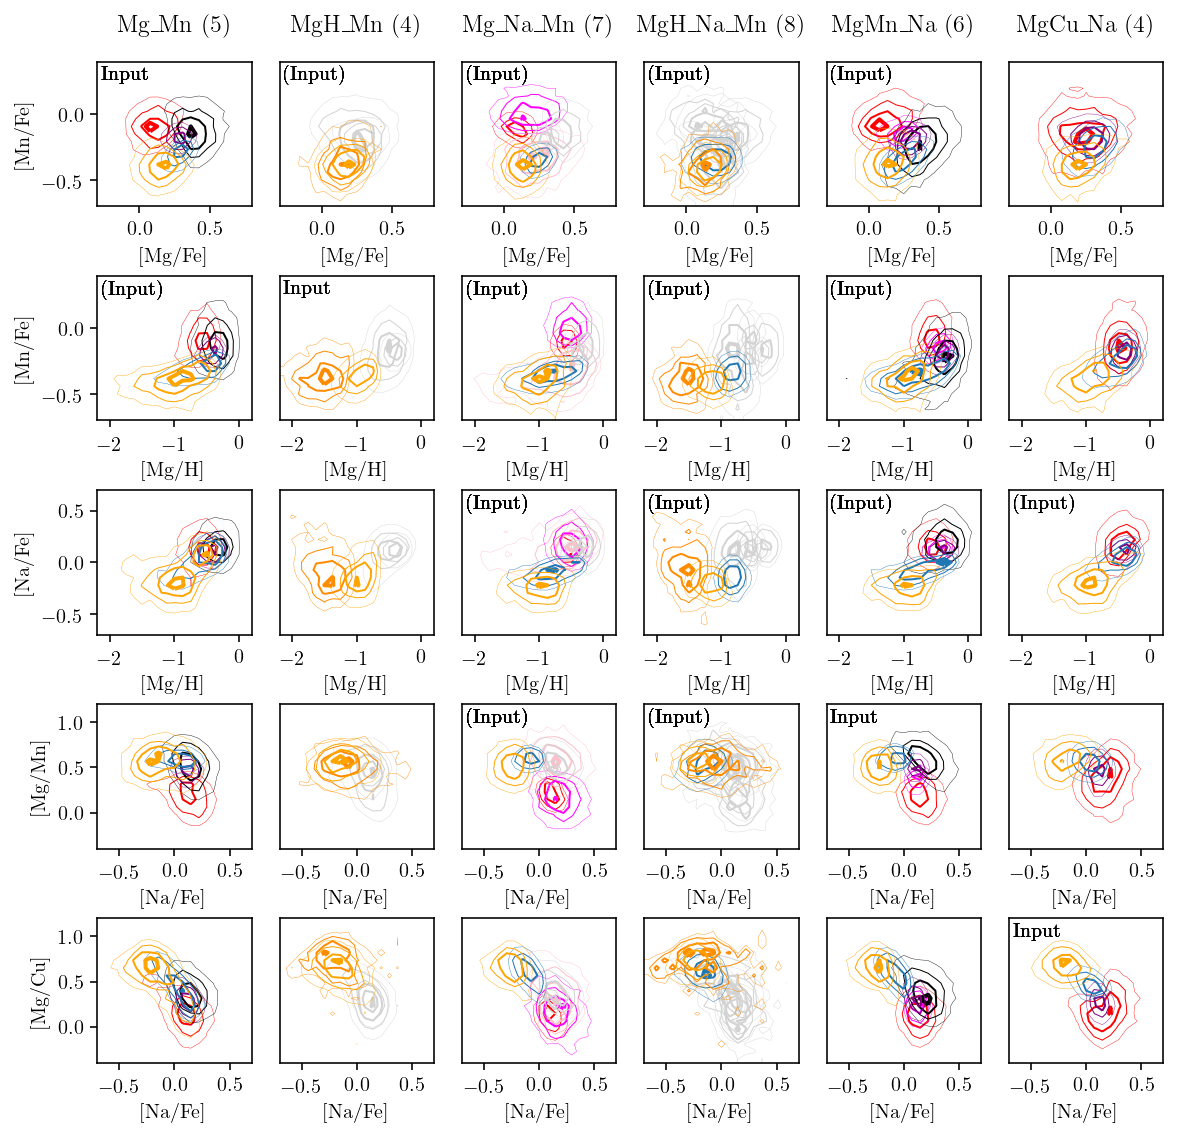

Mg_Mn [4, 0, 3, 2, 1]
MgH_Mn [3, 0, 1, 2]
Mg_Na_Mn [5, 6, 2, 4, 0, 1, 3]


MgH_Na_Mn [5, 7, 3, 2, 0, 6, 4, 1]


MgMn_Na [5, 1, 0, 2, 3, 4]


MgCu_Na [3, 0, 1, 2]


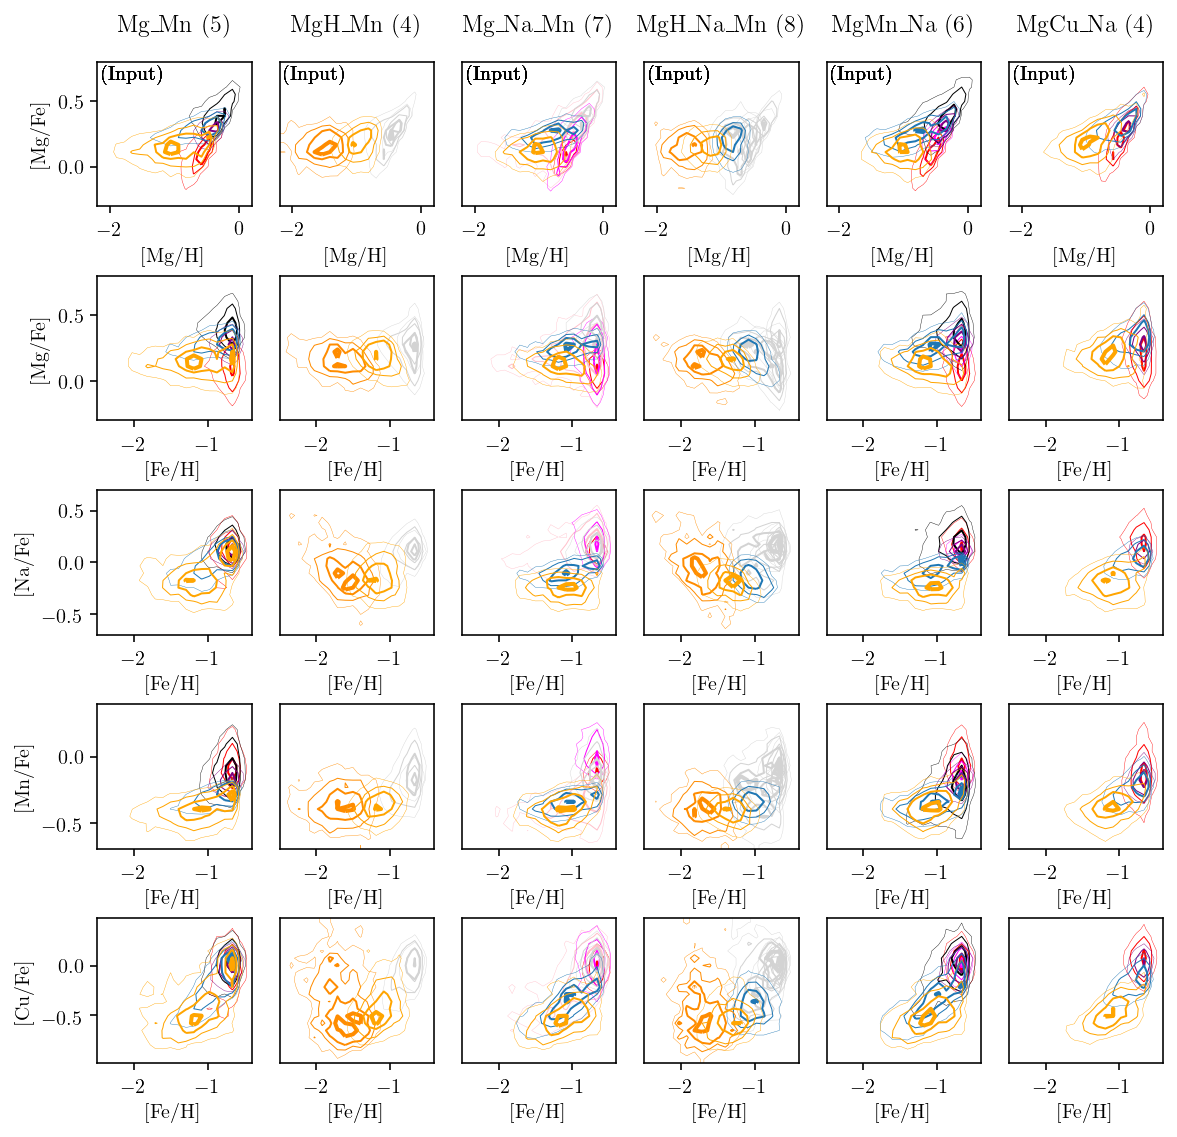

In [84]:
names = ['Mg_Mn','MgH_Mn','Mg_Na_Mn','MgH_Na_Mn','MgMn_Na','MgCu_Na']
gmms = [gmm_Mg_Mn, gmm_MgH_Mn, gmm_Mg_Na_Mn, gmm_MgH_Na_Mn, gmm_MgMn_Na, gmm_MgCu_Na]

# if plot_again:
plot_gmm_overview_2parts_sampled(names, gmms, saveas='best_gmm_samplings',probability_threshold=0.25)

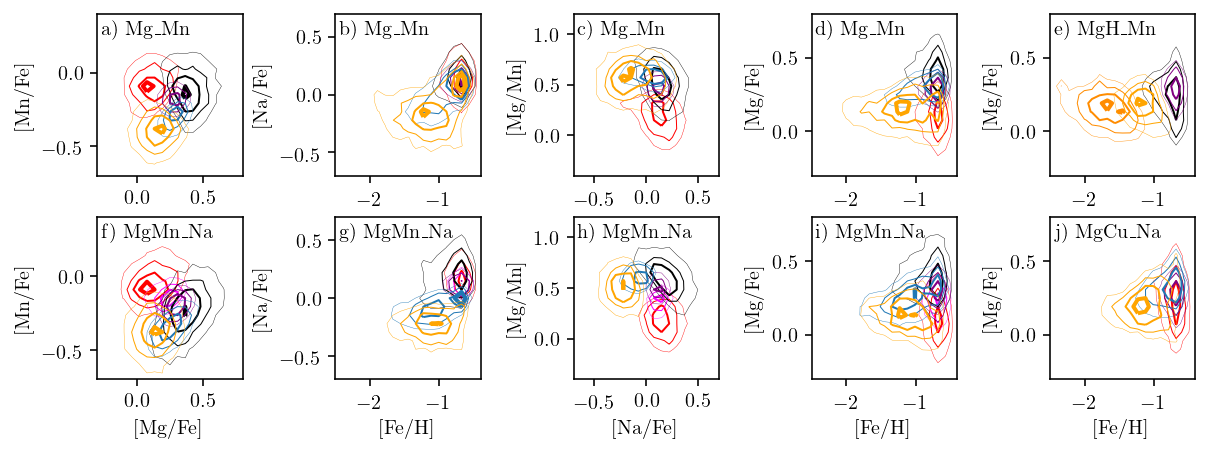

In [111]:
def plot_gmm_overview_paper(
    probability_threshold = 0.25,
    plot_rest_grey = True
    ):
    
    names = [
        'Mg_Mn','Mg_Mn','Mg_Mn','Mg_Mn','MgH_Mn',
        'MgMn_Na','MgMn_Na','MgMn_Na','MgMn_Na','MgCu_Na'
    ]
    gmms = [gmm_Mg_Mn,gmm_Mg_Mn,gmm_Mg_Mn,gmm_Mg_Mn,gmm_MgH_Mn,
            gmm_MgMn_Na,gmm_MgMn_Na,gmm_MgMn_Na,gmm_MgMn_Na,gmm_MgCu_Na]

    f, gs = plt.subplots(2,5,figsize=(8.5,3.25))
    
    ranges = dict()
    ranges['Fe'] = (-2.5,-0.4)
    ranges['Mg'] = (-0.3,0.8)
    ranges['Si'] = (-0.3,0.8)
    ranges['Na'] = (-0.7,0.7)
    ranges['Mn'] = (-0.7,0.4)
    ranges['Ni'] = (-0.98,0.48)
    ranges['Cu'] = (-0.98,0.48)
    ranges['MgH'] = (-2.2,0.2)
    ranges['MgMn'] = (-0.4,1.2)
    ranges['MgCu'] = (-0.4,1.2)

    c_accreted1 = 'orange'
    c_accreted2 = 'darkorange'
    c_intermediate = 'C0'
    c_lowalphadisk = 'red'
    c_highalpha1 = 'purple'
    c_highalpha2 = 'k'
    c_highalpha3 = 'magenta'
    c_highalpha4 = 'pink'
    c_rest = 'lightgrey'

    for ind, (gmm, name) in enumerate(zip(gmms,names)):
        if ind < 5:
            ax = gs[0,ind]
        else:
            ax = gs[1,ind-5]
        ax.text(0.025,0.875,panels[ind]+' '+name.replace('_','\_'),transform=ax.transAxes)
        
        if ind in [0,5]:
            if ind >= 5:
                ax.set_xlabel('[Mg/Fe]')
            ax.set_ylabel('[Mn/Fe]')
        elif ind in [1,6]:
            if ind >= 5:
                ax.set_xlabel('[Fe/H]')
            ax.set_ylabel('[Na/Fe]')
        elif ind in [2,7]:
            if ind >= 5:
                ax.set_xlabel('[Na/Fe]')
            ax.set_ylabel('[Mg/Mn]')
        elif ind in [3,8]:
            if ind >= 5:
                ax.set_xlabel('[Fe/H]')
            ax.set_ylabel('[Mg/Fe]')
        elif ind in [4,9]:
            if ind >= 5:
                ax.set_xlabel('[Fe/H]')
            ax.set_ylabel('[Mg/Fe]')        
        
        if name == 'Mg_Mn':
            components = [1,2,3,0,4][::-1]
        elif name == 'MgH_Mn':
            components = [2,1,0,3][::-1]
        elif name == 'MgMn_Na':
            components = [4,3,2,0,1,5][::-1]
        elif name == 'MgCu_Na':
            components = [2,1,0,3][::-1]
        else:
            components = np.arange(gmm['best_gmm'].n_components)

        corner_kwargs = dict(
            no_fill_contours=True,
            plot_datapoints=False,
            plot_density=False
            #contour_kwargs = dict(linewidths=[0.2,0.5,1,2])
        )
        
        if ind in [0,1,2,3]:
            colors = [c_accreted1,c_intermediate,c_highalpha1,c_highalpha2,c_lowalphadisk][::-1]
        if ind == 4:
            colors = [c_accreted1,c_accreted2,c_highalpha1,c_highalpha2][::-1]
        if ind in [5,6,7,8,9]:
            colors = [c_accreted1,c_intermediate,c_highalpha1,c_highalpha2,c_highalpha3,c_lowalphadisk][::-1]
        if ind == 9:
            colors = [c_accreted1,c_intermediate,c_highalpha1,c_lowalphadisk][::-1]

        if ind in [0,5]:               
            for each_ind, each_component in enumerate(components):
                # [Mg/Fe] vs. [Mn/Fe]
                above_threshold = (
                    (gmm['sampled_probablity'][:,each_component] > probability_threshold) &
                    (data['flag_Mg_fe'][gmm['selection']] == 0) &
                    (data['flag_Mn_fe'][gmm['selection']] == 0)
                )
                corner.hist2d(
                    data['Mg_fe'][gmm['selection']][above_threshold],
                    data['Mn_fe'][gmm['selection']][above_threshold],  
                    ax=ax,
                    color=colors[each_ind],
                    contour_kwargs = dict(linewidths=[0.2,0.5,1,2]),
                    bins = (
                        np.linspace(ranges['Mg'][0],ranges['Mg'][1],20),
                        np.linspace(ranges['Mn'][0],ranges['Mn'][1],20)
                    ),
                    weights = gmm['sampled_probablity'][:,each_component][above_threshold],
                    range=[ranges['Mg'],ranges['Mn']],
                    **corner_kwargs
                )
        elif ind in [1,6]:
            for each_ind, each_component in enumerate(components):
                # [Fe/H] vs. [Na/Fe]
                above_threshold = (
                    (gmm['sampled_probablity'][:,each_component] > probability_threshold) &
                    (data['flag_Na_fe'][gmm['selection']] == 0)
                )
                corner.hist2d(
                    data['fe_h'][gmm['selection']][above_threshold],
                    data['Na_fe'][gmm['selection']][above_threshold],  
                    ax=ax,
                    color=colors[each_ind],
                    contour_kwargs = dict(linewidths=[0.2,0.5,1,2]),
                    bins = (
                        np.linspace(ranges['Fe'][0],ranges['Fe'][1],20),
                        np.linspace(ranges['Na'][0],ranges['Na'][1],20)
                    ),
                    weights = gmm['sampled_probablity'][:,each_component][above_threshold],
                    range=[ranges['Fe'],ranges['Na']],
                    **corner_kwargs
                )
        elif ind in [2,7]:
            for each_ind, each_component in enumerate(components):
                # [Na/Fe] vs. [Mg/Mn]
                above_threshold = (
                    (gmm['sampled_probablity'][:,each_component] > probability_threshold) &
                    (data['flag_Mg_fe'][gmm['selection']] == 0) &
                    (data['flag_Na_fe'][gmm['selection']] == 0) &
                    (data['flag_Mn_fe'][gmm['selection']] == 0)
                )
                corner.hist2d(
                    data['Na_fe'][gmm['selection']][above_threshold],  
                    data['Mg_fe'][gmm['selection']][above_threshold]-data['Mn_fe'][gmm['selection']][above_threshold],
                    ax=ax,
                    color=colors[each_ind],
                    contour_kwargs = dict(linewidths=[0.2,0.5,1,2]),
                    bins = (
                        np.linspace(ranges['Na'][0],ranges['Na'][1],20),
                        np.linspace(ranges['MgMn'][0],ranges['MgMn'][1],20)
                    ),
                    weights = gmm['sampled_probablity'][:,each_component][above_threshold],
                    range=[ranges['Na'],ranges['MgMn']],
                    **corner_kwargs
                )
        elif ind in [3,8]:
            for each_ind, each_component in enumerate(components):
                # [Fe/H] vs. [Mg/Fe]
                above_threshold = (
                    (gmm['sampled_probablity'][:,each_component] > probability_threshold) &
                    (data['flag_Mg_fe'][gmm['selection']] == 0)
                )
                corner.hist2d(
                    data['fe_h'][gmm['selection']][above_threshold],  
                    data['Mg_fe'][gmm['selection']][above_threshold],
                    ax=ax,
                    color=colors[each_ind],
                    contour_kwargs = dict(linewidths=[0.2,0.5,1,2]),
                    bins = (
                        np.linspace(ranges['Fe'][0],ranges['Fe'][1],20),
                        np.linspace(ranges['Mg'][0],ranges['Mg'][1],20)
                    ),
                    weights = gmm['sampled_probablity'][:,each_component][above_threshold],
                    range=[ranges['Fe'],ranges['Mg']],
                    **corner_kwargs
                )
        elif ind in [4,9]:
            for each_ind, each_component in enumerate(components):
                # [Fe/H] vs. [Mg/Fe]
                above_threshold = (
                    (gmm['sampled_probablity'][:,each_component] > probability_threshold) &
                    (data['flag_Mg_fe'][gmm['selection']] == 0)
                )
                corner.hist2d(
                    data['fe_h'][gmm['selection']][above_threshold],  
                    data['Mg_fe'][gmm['selection']][above_threshold],
                    ax=ax,
                    color=colors[each_ind],
                    contour_kwargs = dict(linewidths=[0.2,0.5,1,2]),
                    bins = (
                        np.linspace(ranges['Fe'][0],ranges['Fe'][1],20),
                        np.linspace(ranges['Mg'][0],ranges['Mg'][1],20)
                    ),
                    weights = gmm['sampled_probablity'][:,each_component][above_threshold],
                    range=[ranges['Fe'],ranges['Mg']],
                    **corner_kwargs
                )
        else:
            pass

    plt.tight_layout(w_pad=0.5,h_pad=0.5)
    plt.savefig('best_gmm_samplings_selection.png',dpi=200,bbox_inches='tight')
    plt.show()
    plt.close()

plot_gmm_overview_paper()

In [30]:
names = ['MgH_Na','Mg_Na_Cu','Mg_Na_Mn_Cu','all_six','all_sixb']
gmms = [gmm_MgH_Na, gmm_Mg_Na_Cu, gmm_Mg_Na_Mn_Cu, gmm_all_six,gmm_all_sixb]

if plot_again:
    plot_gmm_overview(names, gmms, saveas='worst_gmm_not_sampled.png')

# B Outcome of this

In [31]:
# Mg_Mn_catalogue = Table()
# Mg_Mn_catalogue['source_id_dr3'] = data['dr3_source_id_1'][gmm_Mg_Mn['selection']]
# Mg_Mn_catalogue['sobject_id'] = data['sobject_id'][gmm_Mg_Mn['selection']]
# Mg_Mn_catalogue['Mg_Mn_prob_accr_1'] = np.array(np.around(gmm_Mg_Mn['sampled_probablity'][:,1],decimals=2),dtype=np.float32)
# Mg_Mn_catalogue['Mg_Mn_prob_mpia'] = np.array(np.around(gmm_Mg_Mn['sampled_probablity'][:,2],decimals=2),dtype=np.float32)
# Mg_Mn_catalogue['Mg_Mn_prob_max'] = np.array(np.argmax(gmm_Mg_Mn['sampled_probablity'],axis=1),dtype=np.int)

# MgH_Mn_catalogue = Table()
# MgH_Mn_catalogue['sobject_id'] = data['sobject_id'][gmm_MgH_Mn['selection']]
# MgH_Mn_catalogue['MgH_Mn_prob_accr_1'] = np.array(np.around(gmm_MgH_Mn['sampled_probablity'][:,2],decimals=2),dtype=np.float32)
# MgH_Mn_catalogue['MgH_Mn_prob_accr_2'] = np.array(np.around(gmm_MgH_Mn['sampled_probablity'][:,1],decimals=2),dtype=np.float32)
# MgH_Mn_catalogue['MgH_Mn_prob_max'] = np.array(np.argmax(gmm_MgH_Mn['sampled_probablity'],axis=1),dtype=np.int)

# Mg_Na_Mn_catalogue = Table()
# Mg_Na_Mn_catalogue['sobject_id'] = data['sobject_id'][gmm_Mg_Na_Mn['selection']]
# Mg_Na_Mn_catalogue['Mg_Na_Mn_prob_accr_1'] = np.array(np.around(gmm_Mg_Na_Mn['sampled_probablity'][:,3],decimals=2),dtype=np.float32)
# Mg_Na_Mn_catalogue['Mg_Na_Mn_prob_mpia'] = np.array(np.around(gmm_Mg_Na_Mn['sampled_probablity'][:,1],decimals=2),dtype=np.float32)
# Mg_Na_Mn_catalogue['Mg_Na_Mn_prob_max'] = np.array(np.argmax(gmm_Mg_Na_Mn['sampled_probablity'],axis=1),dtype=np.int)

# MgH_Na_Mn_catalogue = Table()
# MgH_Na_Mn_catalogue['sobject_id'] = data['sobject_id'][gmm_MgH_Na_Mn['selection']]
# MgH_Na_Mn_catalogue['MgH_Na_Mn_prob_accr_1'] = np.array(np.around(gmm_MgH_Na_Mn['sampled_probablity'][:,1],decimals=2),dtype=np.float32)
# MgH_Na_Mn_catalogue['MgH_Na_Mn_prob_accr_2'] = np.array(np.around(gmm_MgH_Na_Mn['sampled_probablity'][:,4],decimals=2),dtype=np.float32)
# MgH_Na_Mn_catalogue['MgH_Na_Mn_prob_mpia'] = np.array(np.around(gmm_MgH_Na_Mn['sampled_probablity'][:,6],decimals=2),dtype=np.float32)
# MgH_Na_Mn_catalogue['MgH_Na_Mn_prob_max'] = np.array(np.argmax(gmm_MgH_Na_Mn['sampled_probablity'],axis=1),dtype=np.int)

# MgMn_Na_catalogue = Table()
# MgMn_Na_catalogue['sobject_id'] = data['sobject_id'][gmm_MgMn_Na['selection']]
# MgMn_Na_catalogue['MgMn_Na_prob_accr_1'] = np.array(np.around(gmm_MgMn_Na['sampled_probablity'][:,4],decimals=2),dtype=np.float32)
# MgMn_Na_catalogue['MgMn_Na_prob_mpia'] = np.array(np.around(gmm_MgMn_Na['sampled_probablity'][:,3],decimals=2),dtype=np.float32)
# MgMn_Na_catalogue['MgMn_Na_prob_max'] = np.array(np.argmax(gmm_MgMn_Na['sampled_probablity'],axis=1),dtype=np.int)

# MgCu_Na_catalogue = Table()
# MgCu_Na_catalogue['sobject_id'] = data['sobject_id'][gmm_MgCu_Na['selection']]
# MgCu_Na_catalogue['MgCu_Na_prob_accr_1'] = np.array(np.around(gmm_MgCu_Na['sampled_probablity'][:,2],decimals=2),dtype=np.float32)
# MgCu_Na_catalogue['MgCu_Na_prob_mpia'] = np.array(np.around(gmm_MgCu_Na['sampled_probablity'][:,1],decimals=2),dtype=np.float32)
# MgCu_Na_catalogue['MgCu_Na_prob_max'] = np.array(np.argmax(gmm_MgCu_Na['sampled_probablity'],axis=1),dtype=np.int)

# join1 = join(Mg_Mn_catalogue,MgH_Mn_catalogue,keys='sobject_id',join_type='outer')
# join2 = join(join1,Mg_Na_Mn_catalogue,keys='sobject_id',join_type='outer')
# join3 = join(join2,MgH_Na_Mn_catalogue,keys='sobject_id',join_type='outer')
# join4 = join(join3,MgMn_Na_catalogue,keys='sobject_id',join_type='outer')
# join5 = join(join4,MgCu_Na_catalogue,keys='sobject_id',join_type='outer')
# joined_wo_data = join5

# joined_wo_data.write('../data/GMM_probabilities.fits',overwrite=True)

In [32]:
joined_wo_data = Table.read('../data/GMM_probabilities.fits')
joined = join(joined_wo_data, data, keys='sobject_id')

In [33]:
print('accr/mpia,     [Fe/H]           [Mg/Fe]               [Mg/H]                 [Na/Fe]               [Mn/Fe]')
for group in [
    'Mg_Mn_prob_accr_1',
    'Mg_Na_Mn_prob_accr_1',
    'MgMn_Na_prob_accr_1',
    'MgCu_Na_prob_accr_1',
    'MgH_Mn_prob_accr_1',
    'MgH_Na_Mn_prob_accr_1',
    'MgH_Mn_prob_accr_2',
    'MgH_Na_Mn_prob_accr_2',
    'Mg_Mn_prob_mpia',
    'Mg_Na_Mn_prob_mpia',
    'MgH_Na_Mn_prob_mpia',
    'MgMn_Na_prob_mpia',
    'MgCu_Na_prob_mpia'
    ]:

    #print(group)
    txt = group[-6:].replace('_','\_')
    for elem in ['fe_h','Mg_fe','MgH','Na_fe','Mn_fe']:
        if elem == 'MgH':
            selection = (joined[group] > 0.25) & (joined['flag_Mg_fe'] == 0)
            weighted_stats = DescrStatsW(np.array(joined['Mg_fe'][selection]+joined['fe_h'][selection],dtype=np.float32), weights=np.array(joined[group][selection],dtype=np.float32))
        else:
            selection = (joined[group] > 0.25) & (joined['flag_'+elem] == 0)
            weighted_stats = DescrStatsW(np.array(joined[elem][selection],dtype=np.float32), weights=np.array(joined[group][selection],dtype=np.float32))
        p = weighted_stats.quantile(probs=(0.14,0.5,0.84),return_pandas=False)
        distribution = "{:.2f}".format(p[1])+'_{-'+"{:.2f}".format(p[1]-p[0])+'}^{+'+"{:.2f}".format(p[2]-p[1])+'}'
        if (group == 'Mg_Mn_prob_accr_1') & (elem == 'Na_fe'):
            print('saved ',group,elem,distribution)
            np.savetxt('../depending_text/Mg_Mn_dist1_NaFe.tex',
                       [r'$\mathrm{[Na/Fe]} = '+distribution+r'$%'],fmt='%s')
        if (group == 'MgH_Mn_prob_accr_1') & (elem == 'MgH'):
            print('saved ',group,elem,distribution)
            np.savetxt('../depending_text/MgH_Mn_dist1_MgH.tex',
                       [r'$\mathrm{[Mg/H]} = '+distribution+r'$%'],fmt='%s')
        if (group == 'MgH_Mn_prob_accr_2') & (elem == 'MgH'):
            print('saved ',group,elem,distribution)
            np.savetxt('../depending_text/MgH_Mn_dist2_MgH.tex',
                       [r'$\mathrm{[Mg/H]} = '+distribution+r'$%'],fmt='%s')
        if (group == 'MgH_Mn_prob_accr_1') & (elem == 'Mg_fe'):
            print('saved ',group,elem,distribution)
            np.savetxt('../depending_text/MgH_Mn_dist1_MgFe.tex',
                       [r'$\mathrm{[Mg/Fe]} = '+distribution+r'$%'],fmt='%s')
        if (group == 'MgH_Mn_prob_accr_1') & (elem == 'Na_fe'):
            print('saved ',group,elem,distribution)
            np.savetxt('../depending_text/MgH_Mn_dist1_NaFe.tex',
                       [r'$\mathrm{[Mg/Fe]} = '+distribution+r'$%'],fmt='%s')
        if (group == 'MgH_Mn_prob_accr_2') & (elem == 'Mg_fe'):
            print('saved ',group,elem,distribution)
            np.savetxt('../depending_text/MgH_Mn_dist2_MgFe.tex',
                       [r'$\mathrm{[Mg/Fe]} = '+distribution+r'$%'],fmt='%s')
            
        if (group == 'Mg_Na_Mn_prob_accr_1') & (elem == 'Mg_fe'):
            print('saved ',group,elem,distribution)
            np.savetxt('../depending_text/Mg_Na_Mn_dist1_MgFe.tex',
                       [r'$'+distribution+r'$%'],fmt='%s')
        if (group == 'Mg_Na_Mn_prob_accr_1') & (elem == 'Na_fe'):
            print('saved ',group,elem,distribution)
            np.savetxt('../depending_text/Mg_Na_Mn_dist1_NaFe.tex',
                       [r'$'+distribution+r'$%'],fmt='%s')
        if (group == 'Mg_Na_Mn_prob_accr_1') & (elem == 'Mn_fe'):
            print('saved ',group,elem,distribution)
            np.savetxt('../depending_text/Mg_Na_Mn_dist1_MnFe.tex',
                       [r'$'+distribution+r'$%'],fmt='%s')
        if (group == 'Mg_Na_Mn_prob_mpia') & (elem == 'Mg_fe'):
            print('saved ',group,elem,distribution)
            np.savetxt('../depending_text/Mg_Na_Mn_dist2_MgFe.tex',
                       [r'$'+distribution+r'$%'],fmt='%s')
        if (group == 'Mg_Na_Mn_prob_mpia') & (elem == 'Na_fe'):
            print('saved ',group,elem,distribution)
            np.savetxt('../depending_text/Mg_Na_Mn_dist2_NaFe.tex',
                       [r'$'+distribution+r'$%'],fmt='%s')
        if (group == 'Mg_Na_Mn_prob_mpia') & (elem == 'Mn_fe'):
            print('saved ',group,elem,distribution)
            np.savetxt('../depending_text/Mg_Na_Mn_dist2_MnFe.tex',
                       [r'$'+distribution+r'$%'],fmt='%s')

        if (group == 'MgH_Na_Mn_prob_accr_1') & (elem == 'MgH'):
            print('saved ',group,elem,distribution)
            np.savetxt('../depending_text/MgH_Na_Mn_dist1_MgH.tex',
                       [r'$\mathrm{[Mg/H]} = '+distribution+r'$%'],fmt='%s')
        if (group == 'MgH_Na_Mn_prob_accr_2') & (elem == 'MgH'):
            print('saved ',group,elem,distribution)
            np.savetxt('../depending_text/MgH_Na_Mn_dist2_MgH.tex',
                       [r'$\mathrm{[Mg/H]} = '+distribution+r'$%'],fmt='%s')
        if (group == 'MgH_Na_Mn_prob_mpia') & (elem == 'MgH'):
            print('saved ',group,elem,distribution)
            np.savetxt('../depending_text/MgH_Na_Mn_dist3_MgH.tex',
                       [r'$\mathrm{[Mg/H]} = '+distribution+r'$%'],fmt='%s')

        if (group == 'MgMn_Na_prob_accr_1') & (elem == 'Mn_fe'):
            print('saved ',group,elem,distribution)
            np.savetxt('../depending_text/MgMn_Na_dist1_Mn.tex',
                       [r'$'+distribution+r'$%'],fmt='%s')
        if (group == 'MgMn_Na_prob_mpia') & (elem == 'Mn_fe'):
            print('saved ',group,elem,distribution)
            np.savetxt('../depending_text/MgMn_Na_dist2_Mn.tex',
                       [r'$'+distribution+r'$%'],fmt='%s')


            
        txt = txt+', '+distribution
    #print(txt)

accr/mpia,     [Fe/H]           [Mg/Fe]               [Mg/H]                 [Na/Fe]               [Mn/Fe]
saved  Mg_Mn_prob_accr_1 Na_fe -0.12_{-0.19}^{+0.22}
saved  Mg_Na_Mn_prob_accr_1 Mg_fe 0.12_{-0.11}^{+0.09}
saved  Mg_Na_Mn_prob_accr_1 Na_fe -0.25_{-0.13}^{+0.09}
saved  Mg_Na_Mn_prob_accr_1 Mn_fe -0.40_{-0.12}^{+0.11}
saved  MgMn_Na_prob_accr_1 Mn_fe -0.37_{-0.13}^{+0.12}
saved  MgH_Mn_prob_accr_1 Mg_fe 0.18_{-0.13}^{+0.10}
saved  MgH_Mn_prob_accr_1 MgH -0.97_{-0.23}^{+0.18}
saved  MgH_Mn_prob_accr_1 Na_fe -0.14_{-0.16}^{+0.17}
saved  MgH_Na_Mn_prob_accr_1 MgH -1.18_{-0.22}^{+0.17}
saved  MgH_Mn_prob_accr_2 Mg_fe 0.15_{-0.12}^{+0.11}
saved  MgH_Mn_prob_accr_2 MgH -1.52_{-0.34}^{+0.24}
saved  MgH_Na_Mn_prob_accr_2 MgH -1.56_{-0.28}^{+0.21}
saved  Mg_Na_Mn_prob_mpia Mg_fe 0.25_{-0.08}^{+0.07}
saved  Mg_Na_Mn_prob_mpia Na_fe -0.10_{-0.09}^{+0.08}
saved  Mg_Na_Mn_prob_mpia Mn_fe -0.35_{-0.08}^{+0.07}
saved  MgH_Na_Mn_prob_mpia MgH -0.83_{-0.16}^{+0.13}
saved  MgMn_Na_prob_mpia Mn_fe

In [34]:
def save_sample_gmm():
    table = [
        [r'\begin{table}'],
        [r'\centering'],
        [r'\caption{Overview of the combinations used for the Simple Gaussian Mixture Models to estimate the number of components to sample out. The GMM input, consisting of the number of data points with each combination as input array has yielded the lowest BIC score for the number of components lists.}'],
        [r'\label{tab:sample_gmm}'],
        [r'\begin{tabular}{cccc}'],
        [r'\hline \hline'],
        [r'Set & \multicolumn{2}{c}{Input for simple GMMs (see Sec.~\ref{sec:sample_gmm})} & Comp. \\'],
        [r' & Combination & Data Points & Nr. \\'],
        [r'\hline'],
        [r'\texttt{Mg\_Mn}   & [Mg/Fe], [Mn/Fe]  & '+str(len(gmm_Mg_Mn['gmm_input']))+' & '+str(gmm_Mg_Mn['best_gmm'].n_components)+r' \\'],
        [r'\texttt{MgH\_Mn}  & [Mg/H], [Mn/Fe]   & '+str(len(gmm_MgH_Mn['gmm_input']))+' & '+str(gmm_MgH_Mn['best_gmm'].n_components)+r' \\'],
        [r'\texttt{Mg\_Na\_Mn}  & [Mg/Fe], [Na/Fe], [Mn/Fe] & '+str(len(gmm_Mg_Na_Mn['gmm_input']))+' & '+str(gmm_Mg_Na_Mn['best_gmm'].n_components)+r' \\'],
        [r'\texttt{MgH\_Na\_Mn} & [Mg/H], [Na/Fe], [Mn/Fe] & '+str(len(gmm_MgH_Na_Mn['gmm_input']))+' & '+str(gmm_MgH_Na_Mn['best_gmm'].n_components)+r' \\'],
        [r'\texttt{MgMn\_Na}  & [Mg/Mn], [Na/Fe]  & '+str(len(gmm_MgMn_Na['gmm_input']))+' & '+str(gmm_MgMn_Na['best_gmm'].n_components)+r' \\'],
        [r'\texttt{MgCu\_Na}  & [Mg/Cu], [Na/Fe]  & '+str(len(gmm_MgCu_Na['gmm_input']))+' & '+str(gmm_MgCu_Na['best_gmm'].n_components)+r' \\'],
        [r'\hline'],
        [r'\texttt{MgH\_Na}  & [Mg/H], [Na/Fe]   & '+str(len(gmm_MgH_Na['gmm_input']))+' & '+str(gmm_MgH_Na['best_gmm'].n_components)+r' \\'],
        [r'\texttt{Mg\_Na\_Cu}  & [Mg/Fe], [Na/Fe], [Cu/Fe] & '+str(len(gmm_Mg_Na_Cu['gmm_input']))+' & '+str(gmm_Mg_Na_Cu['best_gmm'].n_components)+r' \\'],
        [r'\texttt{Mg\_Na\_Mn\_Cu} & [Mg/Fe], [Na/Fe],   & '+str(len(gmm_Mg_Na_Mn_Cu['gmm_input']))+' & '+str(gmm_Mg_Na_Mn_Cu['best_gmm'].n_components)+r' \\'],
        [r'     & [Mn/Fe], [Cu/Fe]  &   &  \\'],
        [r'\texttt{all\_6}   & [Mg/Fe], [Si/Fe], [Na/Fe], & '+str(len(gmm_all_six['gmm_input']))+' & '+str(gmm_all_six['best_gmm'].n_components)+r' \\'],
        [r'     & [Mn/Fe], [Ni/Fe], [Cu/Fe] &   &  \\'],
        [r'\texttt{all\_6\_rel}  & [Mg/Mn], [Si/Cu],  & '+str(len(gmm_all_sixb['gmm_input']))+' & '+str(gmm_all_sixb['best_gmm'].n_components)+r' \\'],
        [r'     & [Na/Fe], [Ni/Fe]   &   &  \\'],
        [r'   \hline'],
        [r'\end{tabular}'],
        [r'\end{table}']
    ]
    np.savetxt('../tables/gmm_sampling.tex',table,fmt='%s')

save_sample_gmm()

In [35]:
def save_simple_gmm_selection_table():

    table = [
        [r'\begin{table*}'],
        [r'\centering'],
        [r'\caption{Sources selected via the different chemical selections. We highlight the probability in bold face, if it is the largest among the fitted components. The full table is available online together with a crossmatch with the GALAH+DR3 main and value-added-catalogs in a FITS file.}'],
        [r'\label{tab:simple_gmm_selection}'],
        [r'\setlength{\tabcolsep}{0.6em}'],
        [r'\begin{tabular}{cccccccccccccc}'],
        [r'\hline'],
        ['GALAH+ DR3'+
         r' & \multicolumn{2}{c}{\texttt{Mg\_Mn}}'+
         r' & \multicolumn{2}{c}{\texttt{MgH\_Mn}}'+
         r' & \multicolumn{2}{c}{\texttt{Mg\_Na\_Mn}}'+
         r' & \multicolumn{3}{c}{\texttt{MgH\_Na\_Mn}}'+
         r' & \multicolumn{2}{c}{\texttt{MgMn\_Na}}'+
         r' & \multicolumn{2}{c}{\texttt{MgCu\_Na}}'+
         ' \\\\'
        ],
        [r'sobject\_id'+
         ' & Ac. MR'+ # Mg_Mn
         r' & MP-i$\alpha$'+ # Mg_Mn
         ' & Ac. MR'+ # MgH_Mn
         ' & Ac. MP'+ # MgH_Mn
         ' & Ac. MR'+ # Mg_Na_Mn
         r' & MP-i$\alpha$'+ # Mg_Na_Mn
         ' & Ac. MR'+ # MgH_Na_Mn
         ' & Ac. MP'+ # MgH_Na_Mn
         r' & MP-i$\alpha$'+ # MgH_Na_Mn
         ' & Ac. MR'+ # MgMn_Na
         r' & MP-i$\alpha$'+ # MgMn_Na
         ' & Ac. MR'+ # MgCu_Na
         r' & MP-i$\alpha$'+ # MgCu_Na
         ' \\\\'
        ],
        [r'\hline']
    ]

    for i in range(5):
        
        Mg_Mn_accr1_text = str(joined_wo_data['Mg_Mn_prob_accr_1'][i])
        if joined_wo_data['Mg_Mn_prob_max'][i] == 1:
            Mg_Mn_accr1_text = r'\textbf{'+Mg_Mn_accr1_text+'}'
        Mg_Mn_mpia_text = str(joined_wo_data['Mg_Mn_prob_mpia'][i])
        if joined_wo_data['Mg_Mn_prob_max'][i] == 2:
            Mg_Mn_mpia_text = r'\textbf{'+Mg_Mn_mpia_text+'}'
        MgH_Mn_accr1_text = str(joined_wo_data['MgH_Mn_prob_accr_1'][i])
        if joined_wo_data['MgH_Mn_prob_max'][i] == 2:
            MgH_Mn_accr1_text = r'\textbf{'+MgH_Mn_accr1_text+'}'
        MgH_Mn_accr2_text = str(joined_wo_data['MgH_Mn_prob_accr_2'][i])
        if joined_wo_data['MgH_Mn_prob_max'][i] == 1:
            MgH_Mn_accr2_text = r'\textbf{'+MgH_Mn_accr2_text+'}'
        Mg_Na_Mn_accr1_text = str(joined_wo_data['Mg_Na_Mn_prob_accr_1'][i])
        if joined_wo_data['Mg_Na_Mn_prob_max'][i] == 2:
            Mg_Na_Mn_accr1_text = r'\textbf{'+Mg_Na_Mn_accr1_text+'}'
        Mg_Na_Mn_mpia_text = str(joined_wo_data['Mg_Na_Mn_prob_mpia'][i])
        if joined_wo_data['Mg_Na_Mn_prob_max'][i] == 1:
            Mg_Na_Mn_mpia_text = r'\textbf{'+Mg_Na_Mn_mpia_text+'}'
        MgH_Na_Mn_accr1_text = str(joined_wo_data['MgH_Na_Mn_prob_accr_1'][i])
        if joined_wo_data['MgH_Na_Mn_prob_max'][i] == 1:
            MgH_Na_Mn_accr1_text = r'\textbf{'+MgH_Na_Mn_accr1_text+'}'
        MgH_Na_Mn_accr2_text = str(joined_wo_data['MgH_Na_Mn_prob_accr_2'][i])
        if joined_wo_data['MgH_Na_Mn_prob_max'][i] == 4:
            MgH_Na_Mn_accr2_text = r'\textbf{'+MgH_Na_Mn_accr2_text+'}'
        MgH_Na_Mn_mpia_text = str(joined_wo_data['MgH_Na_Mn_prob_mpia'][i])
        if joined_wo_data['MgH_Na_Mn_prob_max'][i] == 6:
            MgH_Na_Mn_mpia_text = r'\textbf{'+MgH_Na_Mn_mpia_text+'}'
        MgMn_Na_accr1_text = str(joined_wo_data['MgMn_Na_prob_accr_1'][i])
        if joined_wo_data['MgMn_Na_prob_max'][i] == 4:
            MgMn_Na_accr1_text = r'\textbf{'+MgMn_Na_accr1_text+'}'
        MgMn_Na_mpia_text = str(joined_wo_data['MgMn_Na_prob_mpia'][i])
        if joined_wo_data['MgMn_Na_prob_max'][i] == 3:
            MgMn_Na_mpia_text = r'\textbf{'+MgMn_Na_mpia_text+'}'
        MgCu_Na_accr1_text = str(joined_wo_data['MgCu_Na_prob_accr_1'][i])
        if joined_wo_data['MgCu_Na_prob_max'][i] == 2:
            MgCu_Na_accr1_text = r'\textbf{'+MgCu_Na_accr1_text+'}'
        MgCu_Na_mpia_text = str(joined_wo_data['MgCu_Na_prob_mpia'][i])
        if joined_wo_data['MgCu_Na_prob_max'][i] == 1:
            MgCu_Na_mpia_text = r'\textbf{'+MgCu_Na_mpia_text+'}'

        table.append(
            [str(joined_wo_data['sobject_id'][i])+
            ' & '+Mg_Mn_accr1_text+
            ' & '+Mg_Mn_mpia_text+
            ' & '+MgH_Mn_accr1_text+
            ' & '+MgH_Mn_accr2_text+
            ' & '+Mg_Na_Mn_accr1_text+
            ' & '+Mg_Na_Mn_mpia_text+
            ' & '+MgH_Na_Mn_accr1_text+
            ' & '+MgH_Na_Mn_accr2_text+
            ' & '+MgH_Na_Mn_mpia_text+
            ' & '+MgMn_Na_accr1_text+
            ' & '+MgMn_Na_mpia_text+
            ' & '+MgCu_Na_accr1_text+
            ' & '+MgCu_Na_mpia_text+
            ' \\\\'
            ])
    table.append([r'\dots '
                  +' & \dots '
                  +' & \dots '
                  +' & \dots '
                  +' & \dots '
                  +' & \dots '
                  +' & \dots '
                  +' & \dots '
                  +' & \dots '
                  +' & \dots '
                  +' & \dots '
                  +' & \dots '
                  +' & \dots '
                  +' & \dots '
                  +'\\\\'])
    table.append([r'\hline'])
    table.append([r'\end{tabular}'])
    table.append([r'\end{table*}'])

    np.savetxt('../tables/simple_gmm_selection.tex',np.array(table),fmt='%s')

save_simple_gmm_selection_table()

# C) XDGMM [Na/Fe] vs. [Mg/Mn]

In [24]:
element_cuts = dict()
element_cuts['Mg'] = (-0.3,0.7)
element_cuts['Si'] = (-0.3,0.7)
element_cuts['Na'] = (-0.7,0.7)
element_cuts['Mn'] = (-0.7,0.25)
element_cuts['Ni'] = (-0.7,0.25)
element_cuts['Cu'] = (-1.0,0.5)

error_limit = 0.25
fe_h_limit = -0.6
elements = ['Mg','Na','Mn']

xdgmm_nafe_mgmn_selection = (
    basic_cuts &
    (data['fe_h'] < fe_h_limit) &
    np.all([(data[element+'_fe'] <= element_cuts[element][1]) for element in elements],axis=0) &
    np.all([(data[element+'_fe'] >= element_cuts[element][0]) for element in elements],axis=0) &
    np.all([(data['flag_'+element+'_fe'] == 0) for element in elements],axis=0) &
    np.all([(data['e_'+element+'_fe'] <= error_limit) for element in elements],axis=0)
)

x = np.array(data['Na_fe'][xdgmm_nafe_mgmn_selection])
y = np.array(data['Mg_fe'][xdgmm_nafe_mgmn_selection] - data['Mn_fe'][xdgmm_nafe_mgmn_selection])
dx = np.array(data['e_Na_fe'][xdgmm_nafe_mgmn_selection])
dy = np.array(np.sqrt((data['e_Mg_fe'][xdgmm_nafe_mgmn_selection])**2 + (data['Mn_fe'][xdgmm_nafe_mgmn_selection])**2))

# stack the results for computation
X = np.vstack([x, y]).T
Xerr = np.zeros(X.shape + X.shape[-1:])
diag = np.arange(X.shape[-1])
Xerr[:, diag, diag] = np.vstack([dx ** 2, dy ** 2]).T

In [141]:
# XDGMM for [Na/Fe] vs. [Mg/Mn] for [Fe/H] < -0.6

# best_bic = 0
# best_n_components = 0
# for n_components in range(1,11):
#     xdgmm_astroml = XDGMM(method='astroML')
#     #xdgmm_astroml.n_components = n_components
#     #xdgmm_astroml = xdgmm_astroml.fit(X, Xerr)
#     #xdgmm_astroml.save_model('../xdgmm/xdgmm_NaFe_MgMn_'+str(n_components)+'comp_model_astroml.fit')
#     xdgmm_astroml.read_model('../xdgmm/xdgmm_NaFe_MgMn_'+str(n_components)+'comp_model_astroml.fit')
#     current_bic = xdgmm_astroml.bic(X,Xerr)
#     print(n_components, current_bic)
#     if current_bic < best_bic:
#         current_bic = best_bic
#         best_n_components = n_components

best_n_components = 5
xdgmm_nafe_mgmn = XDGMM(method='astroML')
xdgmm_nafe_mgmn.read_model('../xdgmm/xdgmm_NaFe_MgMn_'+str(best_n_components)+'comp_model_astroml.fit')

xdgmm = dict()
xdgmm['selection'] = xdgmm_nafe_mgmn_selection
xdgmm['xdgmm_X'] = X
xdgmm['xdgmm_Xerr'] = Xerr
xdgmm['best_gmm'] = xdgmm_nafe_mgmn
xdgmm['prediction'] = xdgmm_nafe_mgmn.predict(X,Xerr)
xdgmm['prediction_proba'] = xdgmm_nafe_mgmn.predict_proba(X,Xerr)
xdgmm['accreted_proba'] = xdgmm['prediction_proba'][:,0]
xdgmm['intermed_proba'] = xdgmm['prediction_proba'][:,3]

file = open('../data/xdgmm_nafe_mgmn.pickle',mode='wb')
pickle.dump(xdgmm,file)
file.close()

In [ ]:
def table_and_plot_nafe_mgmn_overview():

    gmm = '../xdgmm/xdgmm_.fit'

    selection = (
        basic_cuts &
        (data['flag_Mn_fe'] == 0) &
        (data['flag_Mg_fe'] == 0) &
        (data['fe_h'] < -0.6)
    )

    x_data = np.array(data['Mn_fe'][selection])
    y_data = np.array(data['Mg_fe'][selection])
    dx_data = np.array(data['e_Mn_fe'][selection])
    dy_data = np.array(data['e_Mg_fe'][selection])

    features = np.vstack([x_data, y_data]).T
    features_err = np.zeros(features.shape + features.shape[-1:])
    diag = np.arange(features.shape[-1])
    features_err[:, diag, diag] = np.vstack([dx_data ** 2, dy_data ** 2]).T

    xdgmm_astroml = XDGMM(method='astroML')
    xdgmm_astroml.read_model(gmm)

    prediction = xdgmm_astroml.predict(features, features_err)
    prediction_proba = xdgmm_astroml.predict_proba(features, features_err)

    Table_MnFe_MgFe_6comp = Table()
    Table_MnFe_MgFe_6comp['sobject_id'] = data['sobject_id'][selection]
    Table_MnFe_MgFe_6comp['prediction'] = prediction
    Table_MnFe_MgFe_6comp['prediction_proba'] = prediction_proba
    Table_MnFe_MgFe_6comp.write('../data/Table_MnFe_MgFe_6comp.fits', overwrite=True)

    f, gs = plt.subplots(2,3,figsize=(10,4))

    colors = ['purple','orange','red','k','k','C0']

    mn_lim = (-0.75,0.25)
    mg_lim = (-0.25,0.65)
    feh_lim = (-2.5,-0.4)

    ax = gs[0,0]
    for ei in range(xdgmm_astroml.n_components):
        in_pop = (prediction == ei)
        if ei not in [3,4]:
            corner.hist2d(
                data['Mn_fe'][selection][in_pop],
                data['Mg_fe'][selection][in_pop],
                color=colors[ei],
                plot_datapoints=False,
                plot_density=False,
                contour_kwargs = dict(linewidths=[0.25,0.5,1.0]),
                no_fill_contours=True,
                ax=ax,
                label='Comp '+str(ei)
            )
        else:
            ax.scatter(
                data['Mn_fe'][selection][in_pop],
                data['Mg_fe'][selection][in_pop],
                c = 'k',zorder=10,
                s = 0.1
            )
    ax.set_xlabel('[Mn/Fe]')
    ax.set_xlim(mn_lim)
    ax.set_ylabel('[Mg/Fe]')
    ax.set_ylim(mg_lim)
    ax.set_title('Input Plane (argmax)')

    ax = gs[0,1]
    for ei in range(xdgmm_astroml.n_components):
        in_pop = (prediction == ei)
        if ei not in [3,4]:
            corner.hist2d(
                data['fe_h'][selection][in_pop],
                data['Mg_fe'][selection][in_pop],
                color=colors[ei],
                plot_datapoints=False,
                plot_density=False,
                contour_kwargs = dict(linewidths=[0.25,0.5,1.0]),
                ax=ax,
                label='Comp '+str(ei)
            )
    ax.set_xlabel('[Fe/H]')
    ax.set_xlim(feh_lim)
    ax.set_ylabel('[Mg/Fe]')
    ax.set_ylim(mg_lim)
    ax.set_title('Not fitted (argmax)')

    ax = gs[0,2]
    for ei in range(xdgmm_astroml.n_components):
        in_pop = (prediction == ei)
        if ei not in [3,4]:
            corner.hist2d(
                data['fe_h'][selection][in_pop],
                data['Mn_fe'][selection][in_pop],
                color=colors[ei],
                plot_datapoints=False,
                plot_density=False,
                contour_kwargs = dict(linewidths=[0.25,0.5,1.0]),
                ax=ax,
                label='Comp '+str(ei)
            )
    ax.set_xlabel('[Fe/H]')
    ax.set_xlim(feh_lim)
    ax.set_ylabel('[Mn/Fe]')
    ax.set_ylim(mn_lim)
    ax.set_title('Not fitted (argmax)')

    ax = gs[1,0]
    for ei in range(xdgmm_astroml.n_components):#enumerate([gse,disk,rest]):
        above_40percent = prediction_proba[:,ei] > 0.1
        if ei not in [3,4]:
            corner.hist2d(
                data['Mn_fe'][selection][above_40percent],
                data['Mg_fe'][selection][above_40percent],
                weights=prediction_proba[above_40percent,ei],
                color=colors[ei],
                plot_datapoints=False,
                plot_density=False,
                contour_kwargs = dict(linewidths=[0.25,0.5,1.0]),
                ax=ax,
                no_fill_contours=True,
                label='Comp '+str(ei)
            )
        else:
            ax.scatter(
                data['Mn_fe'][selection][above_40percent],
                data['Mg_fe'][selection][above_40percent],
                c = 'k',zorder=10,
                s = 0.5*prediction_proba[above_40percent,ei]**2
            )
    ax.set_xlabel('[Mn/Fe]')
    ax.set_xlim(mn_lim)
    ax.set_ylabel('[Mg/Fe]')
    ax.set_ylim(mg_lim)
    ax.set_title('Input Plane (Prob-weighted)')

    ax = gs[1,1]
    for ei in range(xdgmm_astroml.n_components):#enumerate([gse,disk,rest]):
        above_40percent = prediction_proba[:,ei] > 0.1
        if ei not in [3,4]:
            corner.hist2d(
                data['fe_h'][selection][above_40percent],
                data['Mg_fe'][selection][above_40percent],
                weights=prediction_proba[above_40percent,ei],
                color=colors[ei],
                plot_datapoints=False,
                plot_density=False,
                contour_kwargs = dict(linewidths=[0.25,0.5,1.0]),
                ax=ax,
                label='Comp '+str(ei)
            )
    ax.set_xlabel('[Fe/H]')
    ax.set_xlim(feh_lim)
    ax.set_ylabel('[Mg/Fe]')
    ax.set_ylim(mg_lim)
    ax.set_title('Not fitted (Prob-weighted)')

    ax = gs[1,2]
    for ei in range(xdgmm_astroml.n_components):#enumerate([gse,disk,rest]):
        above_40percent = prediction_proba[:,ei] > 0.1
        if ei not in [3,4]:
            corner.hist2d(
                data['fe_h'][selection][above_40percent],
                data['Mn_fe'][selection][above_40percent],
                weights=prediction_proba[above_40percent,ei],
                color=colors[ei],
                plot_datapoints=False,
                plot_density=False,
                ax=ax,
                contour_kwargs = dict(linewidths=[0.25,0.5,1.0]),
                label='Comp '+str(ei)
            )
    ax.set_xlabel('[Fe/H]')
    ax.set_xlim(feh_lim)
    ax.set_ylabel('[Mn/Fe]')
    ax.set_ylim(mn_lim)
    ax.set_title('Not fitted (Prob-weighted)')

    plt.tight_layout()
    plt.savefig('XDGMM_MnFe_MgFe.png',dpi=300,bbox_inches='tight')
    plt.show()
    plt.close()

table_and_plot_nafe_mgmn_overview()

4 -31292.784465382836
[2 3]
1 0 3 2


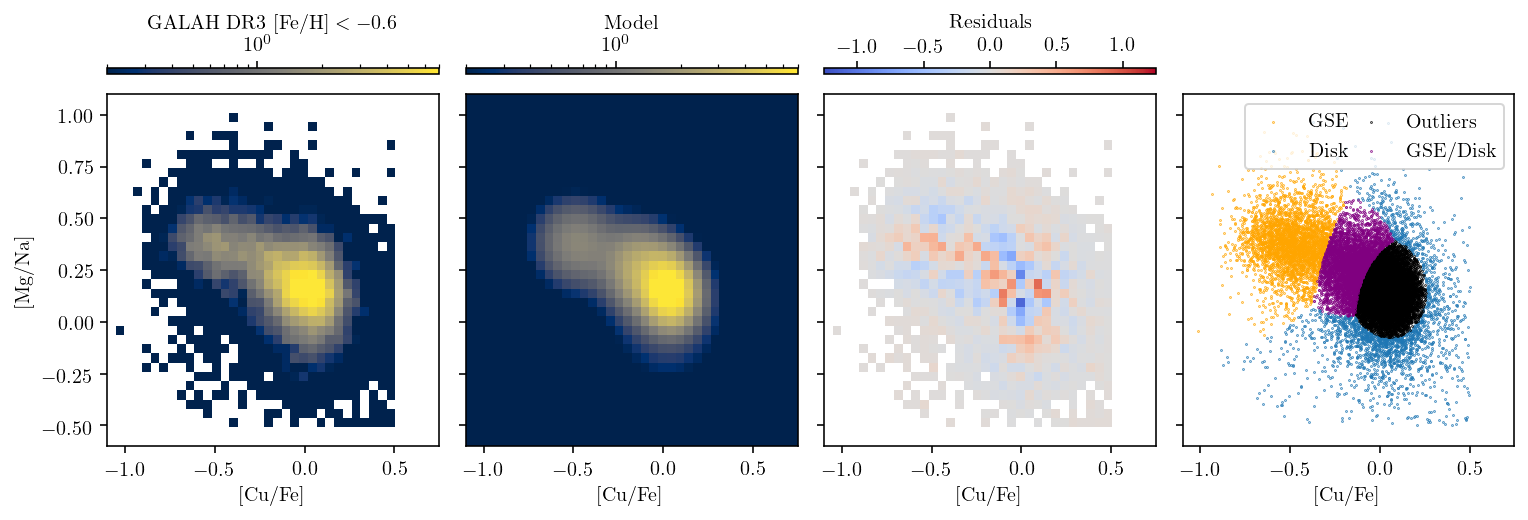

In [152]:
# GMM for [Na/Fe] vs. [Mg/Cu] with 4 components 
fig, gs = plt.subplots(1,4,figsize=(10.5,3.5),sharex=True, sharey=True, constrained_layout=True)

xlim = [-1.1,0.75]
ylim = [-0.6,1.1]

vmin = 0.2
vmax = 7

colors = ['orange','C0','k','purple']
labels = ['GSE','Disk','Outliers','GSE/Disk']

# Select reliable input
selection = (
    basic_cuts &
    (data['flag_Na_fe'] == 0) &
    (data['flag_Cu_fe'] == 0) &
    (data['flag_Mg_fe'] == 0) &
    (data['fe_h'] < -0.6) &
    (data['Cu_fe'] < 0.5) &
    (data['Mg_fe']-data['Na_fe'] > -0.5) &
    (data['Mg_fe']-data['Na_fe'] < 1.0)
)

# Put input in GMM-readible form
GMM_input_MP_CuFe_MgNa = np.array([
        data['Cu_fe'][selection],
        data['Mg_fe'][selection] - data['Na_fe'][selection]
    ]).T

#initialise and fit GMM
gmm = mixture.GaussianMixture(n_components=4, covariance_type='full')
gmm.fit(GMM_input_MP_CuFe_MgNa)
print(4, gmm.bic(GMM_input_MP_CuFe_MgNa))

x = np.linspace(xlim[0], xlim[1],39)
y = np.linspace(ylim[0], ylim[1],39)
dx, dy = x[1]-x[0], y[1]-y[0]

#generate histogram at these bins
hist, xedges,yedges = np.histogram2d(
    GMM_input_MP_CuFe_MgNa[:,0],
    GMM_input_MP_CuFe_MgNa[:,1],
    bins=[x,y])
histnorm = np.sum(hist)*dx*dy
hist = hist/histnorm
poisson = np.sqrt(hist)
histnorm = np.sum(hist)*dx*dy

#find bin centers
xc = (x[1:]+x[:-1])/2.
yc = (y[1:]+y[:-1])/2.
#make a grid at the bin centers
X, Y = np.meshgrid(xc, yc)
XX = np.array([X.ravel(), Y.ravel()]).T
#estimate the gmm density at the bin centers
Z = gmm.score_samples(XX)
Z = Z.reshape(X.shape)
datanorm = np.sum(hist)
modelnorm = np.sum(np.exp(Z))*dx*dy
hist = hist#/datanorm
hist[hist<=0] = np.nan
Z = np.exp(Z)/modelnorm

#find bin centers
xc = (x[1:]+x[:-1])/2.
yc = (y[1:]+y[:-1])/2.
#make a grid at the bin centers
X, Y = np.meshgrid(xc, yc)
XX = np.array([X.ravel(), Y.ravel()]).T
#estimate the gmm density at the bin centers
Z = gmm.score_samples(XX)
Z = Z.reshape(X.shape)
datanorm = np.sum(hist)
modelnorm = np.sum(np.exp(Z))*dx*dy
hist = hist#/datanorm
hist[hist<=0] = np.nan
Z = np.exp(Z)/modelnorm

ax = gs[0]
s = ax.imshow(np.rot90(hist),extent=[xlim[0],xlim[1],ylim[0],ylim[1]],aspect='auto',norm=LogNorm(vmin=vmin,vmax=vmax),cmap='cividis')
c = plt.colorbar(s,ax=ax,location='top')
c.set_label(r'GALAH DR3 $\mathrm{[Fe/H]} < -0.6$')
ax.set_xlabel('[Cu/Fe]')
ax.set_ylabel('[Mg/Na]')


ax = gs[1]
s = ax.imshow(Z[::-1],extent=[xlim[0],xlim[1],ylim[0],ylim[1]],aspect='auto',norm=LogNorm(vmin=vmin,vmax=vmax),cmap='cividis')
c = plt.colorbar(s,ax=ax,location='top')
c.set_label('Model')
ax.set_xlabel('[Cu/Fe]')

ax = gs[2]
residual = np.rot90(hist)-Z[::-1]
s = ax.imshow(residual,extent=[xlim[0],xlim[1],ylim[0],ylim[1]],aspect='auto',vmin=-1.25,vmax=1.25,cmap='coolwarm')
c = plt.colorbar(s,ax=ax,location='top')
c.set_label('Residuals')
ax.set_xlabel('[Cu/Fe]')

prediction = gmm.fit_predict(GMM_input_MP_CuFe_MgNa)

ax = gs[3]
gse = np.where(gmm.means_[:,0] == np.min(gmm.means_[:,0]))[0][0]
disk = np.where((np.abs(gmm.means_[:,0]) == np.min(np.abs(gmm.means_[:,0]))))[0][0]
intersect = []
for i in range(4):
    if i not in [gse,disk]:
        intersect.append(i)
intersect=np.array(intersect)
print(intersect)
rest = np.argmax(gmm.covariances_[intersect,0])
for i in range(4):
    if i not in [gse,disk,rest]:
        intersect = i

print(gse, disk, intersect, rest)

for ei, each in enumerate([gse,disk,rest,intersect]):
    in_pop = (prediction == each)
    #if ei >= 2:
    label = labels[ei]
    #else:
    #    label = '_nolegend_'
    ax.scatter(
        GMM_input_MP_CuFe_MgNa[in_pop,0],
        GMM_input_MP_CuFe_MgNa[in_pop,1],
        s=0.1,color=colors[ei],label=label
    )
ax.set_xlabel('[Cu/Fe]')
ax.legend(ncol=2, columnspacing=0.1)
ax.set_xlim(xlim[0],xlim[1])
ax.set_ylim(ylim[0],ylim[1])

plt.savefig('cufe_mgna_gmm.png',bbox_inches='tight',dpi=200)